# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [13]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits
import time

# My libs
import data
import plots as p
import smhm_fit
import fits


# when we mess up imports
from importlib import reload

In [5]:
matplotlib.rcParams.update({'figure.dpi': 300})
def fig_font_size(size = 12):
    matplotlib.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [6]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load()
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

12.00043407747932
385125


In [30]:
# you should stop messing with sm + icl and at this point just create a unified "stellar_mass" coll
data_stellar_cut = data.sm_cuts_with_sats(centrals, satellites, smhm_fit.get_fit)
data_halo_cut = data.hm_cuts_with_sats(centrals, satellites, smhm_fit.get_fit_2)

/home/christopher/research/hsc_um2/cb/smhm_fit.py:115: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:115: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


In [28]:
x.keys()
x["cen"].keys()
x["cen"]["richness"][0]

(1.509e+14, 10.)

In [8]:
for key in data_stellar_cut.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf"] = (mass, csmf) # note that these masses are log!

In [9]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])
dict_keys(['data', 'fit'])
dict_keys(['data', 'fit', 'smf'])


# Intro Plot

Intro everything by showing the SM-HM plot + some of the sigma plots

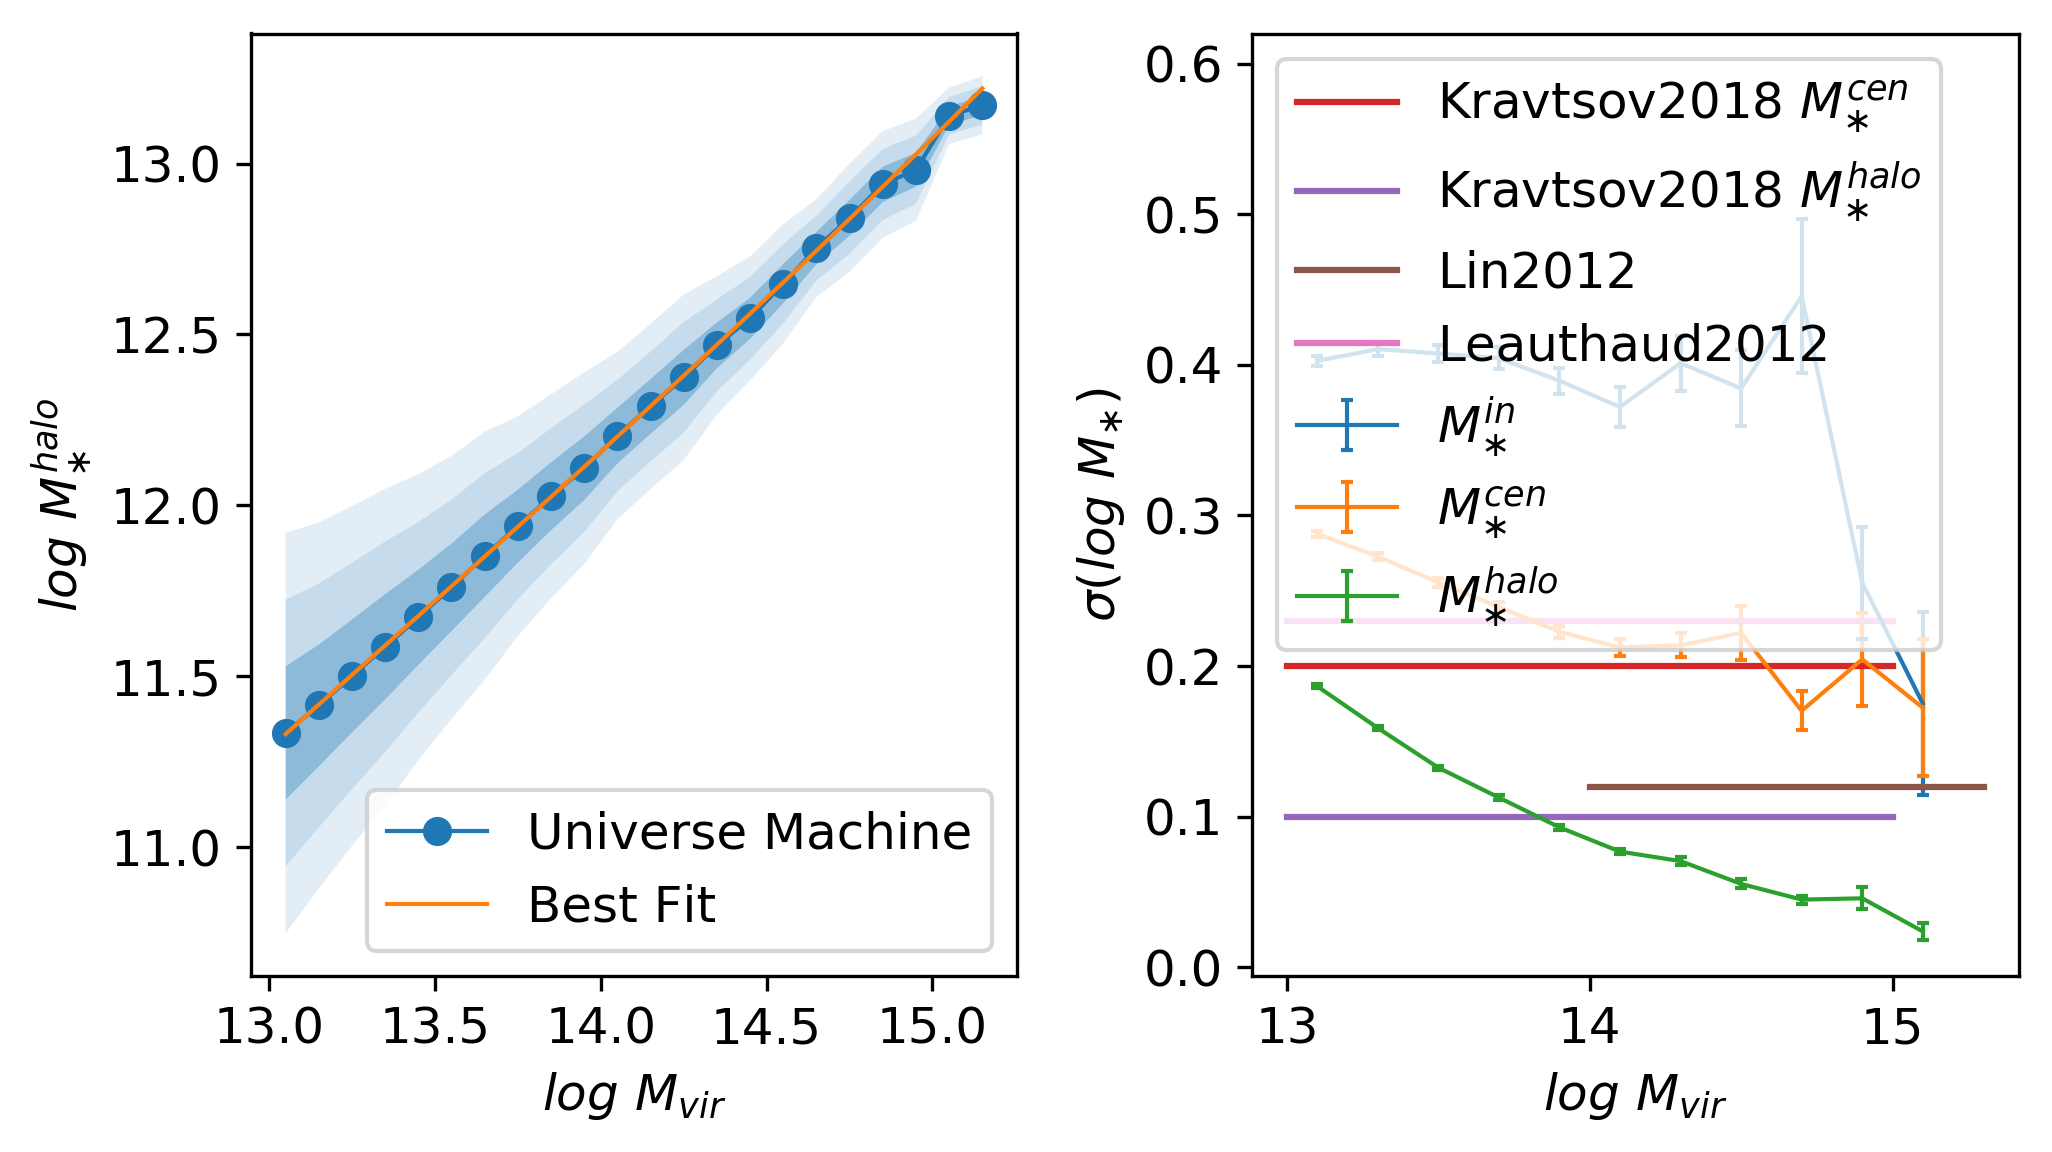

In [15]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_vs_dm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
p.scatter.hm_vs_sm_scatter_variant(data_halo_cut, ax=axes[1])
plt.tight_layout()
#plots.sm_vs_dm(data_halo_cut["cen"]["data"], "cen", fit=data_halo_cut["cen"]["fit"])

# SMHM ratio scatter for clusters

What happens if we start to plot this relation for multiple members of the cluster?

[11.7 11.9 12.1 12.3 12.5]


(0.00335915430251291, 0.40506536413182487)

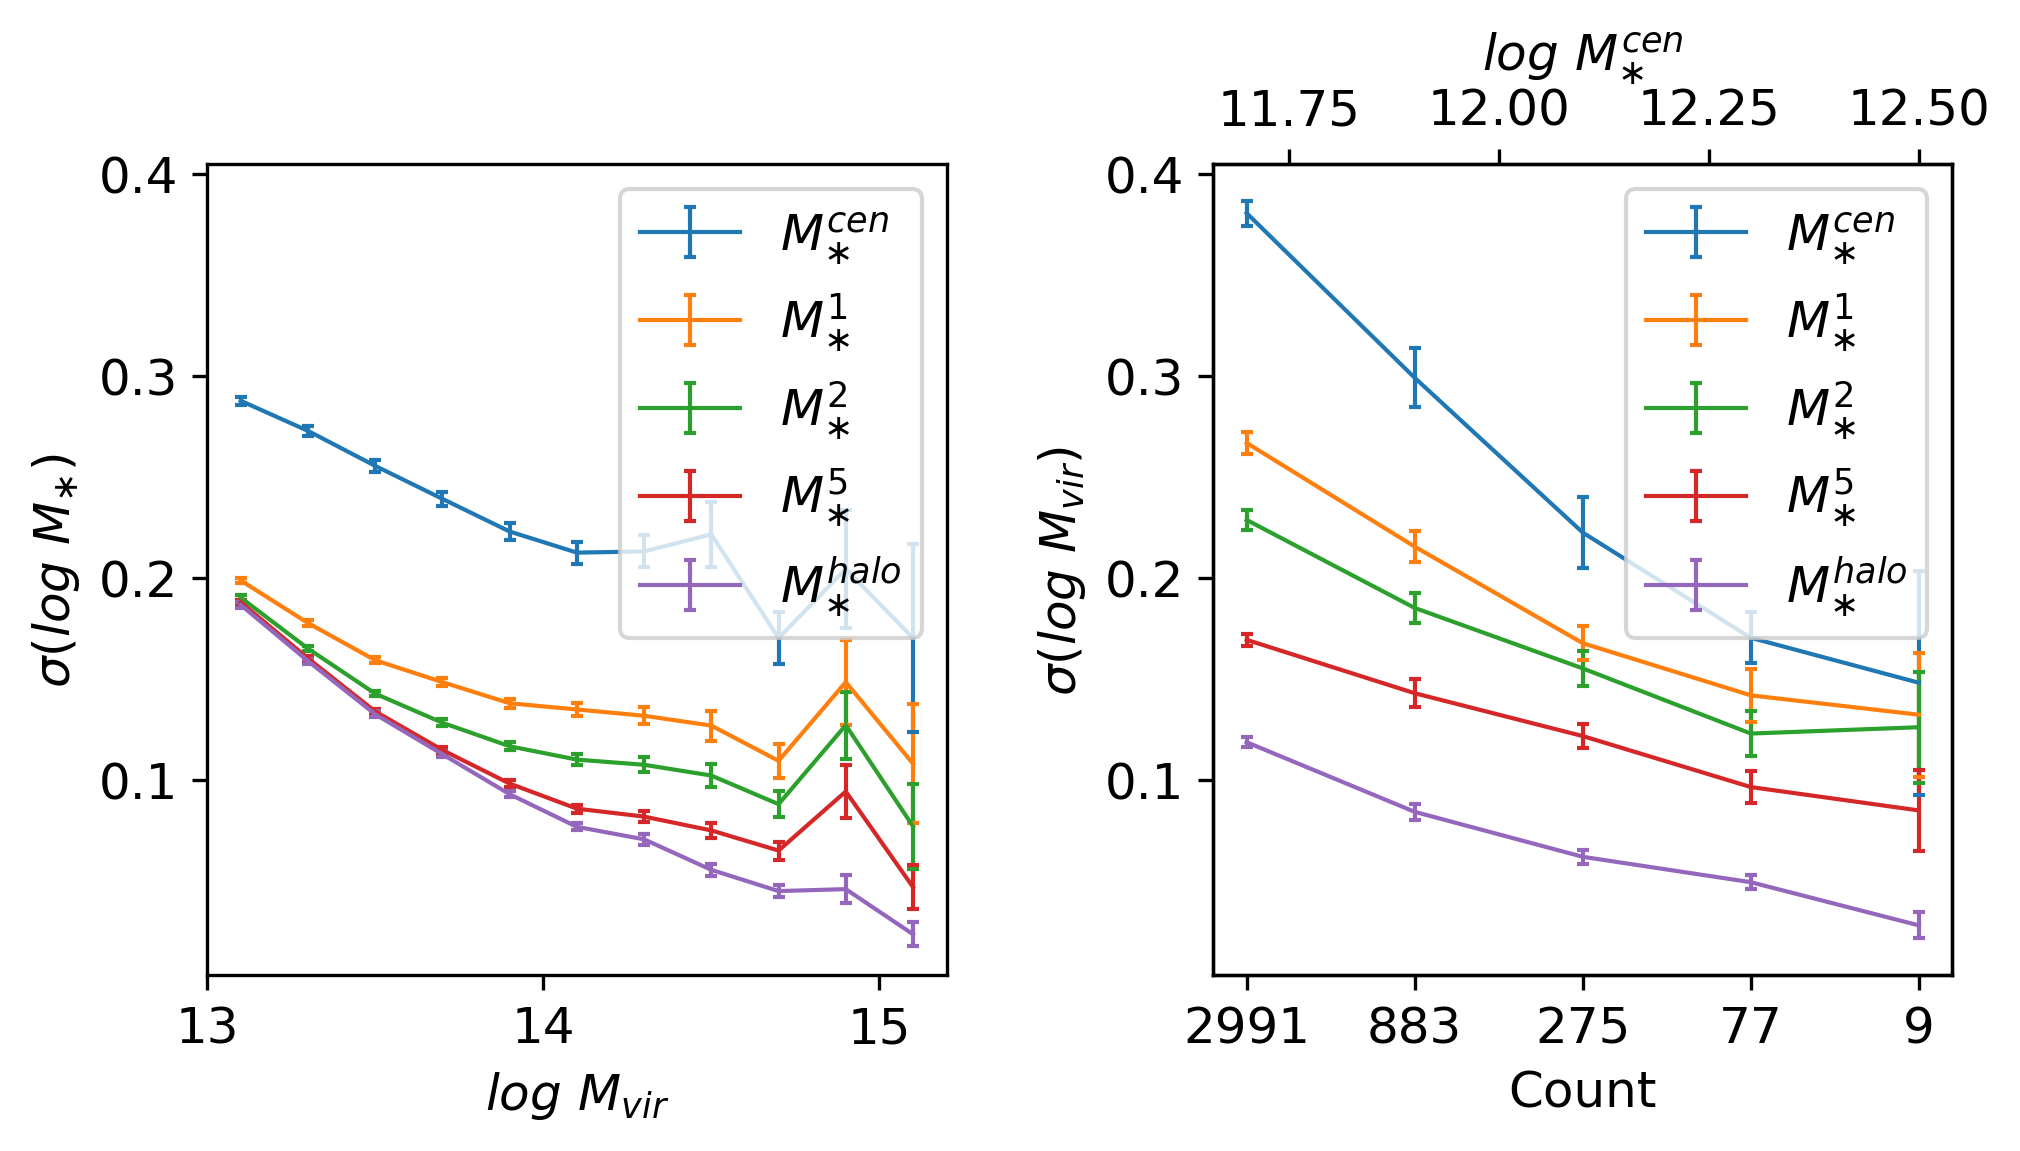

In [17]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
plots.hm_vs_sm_scatter(data_halo_cut, ax=axes[0])
plots.sm_vs_hm_scatter(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# CSMF


In [70]:
fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e-3))

0.0010006356585071535

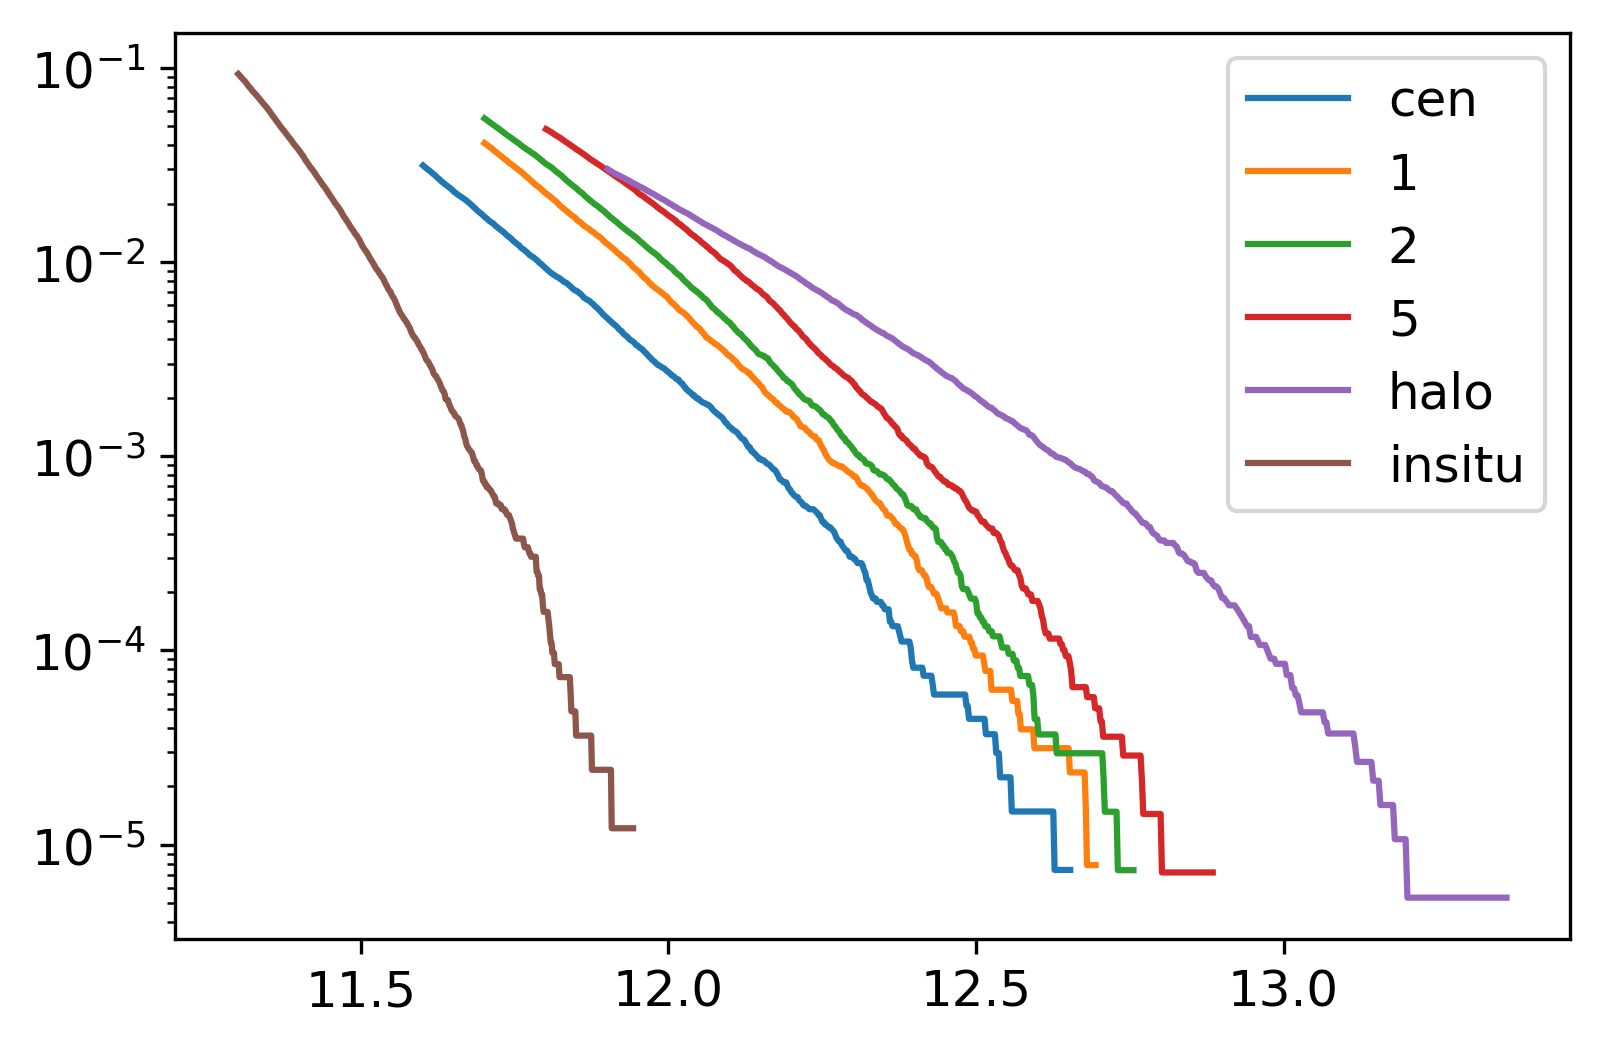

In [57]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [202]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

Dropped 0 galaxies with mass of 0
Dropped 0 galaxies with mass of 0
Dropped 4 galaxies with mass of 0


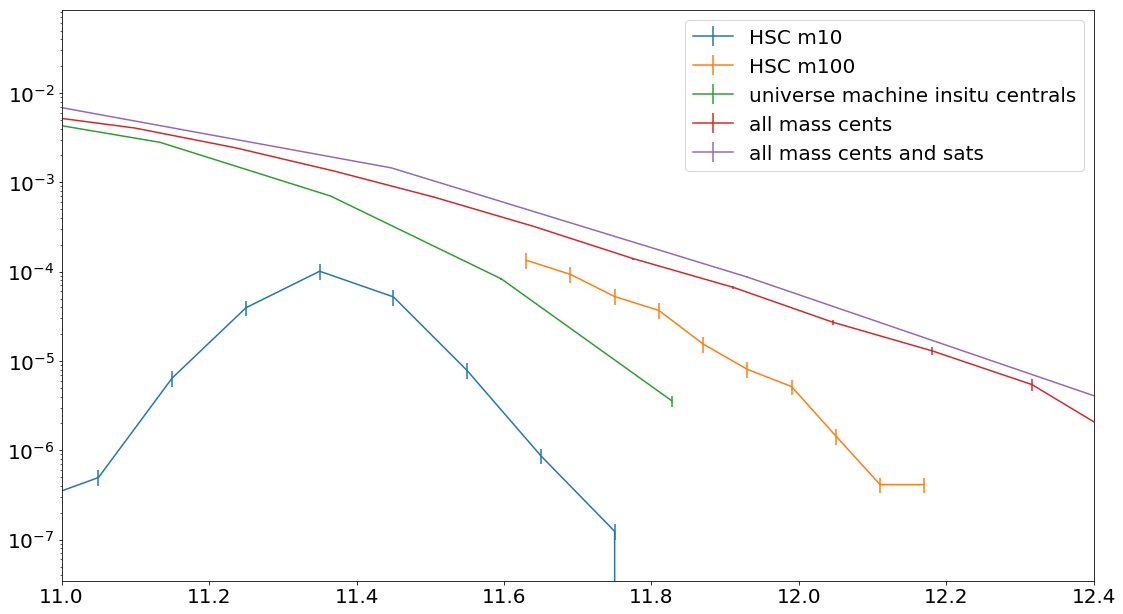

In [210]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness

What about richness? Does that have a relation with scatter at fixed halo mass

[13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2]


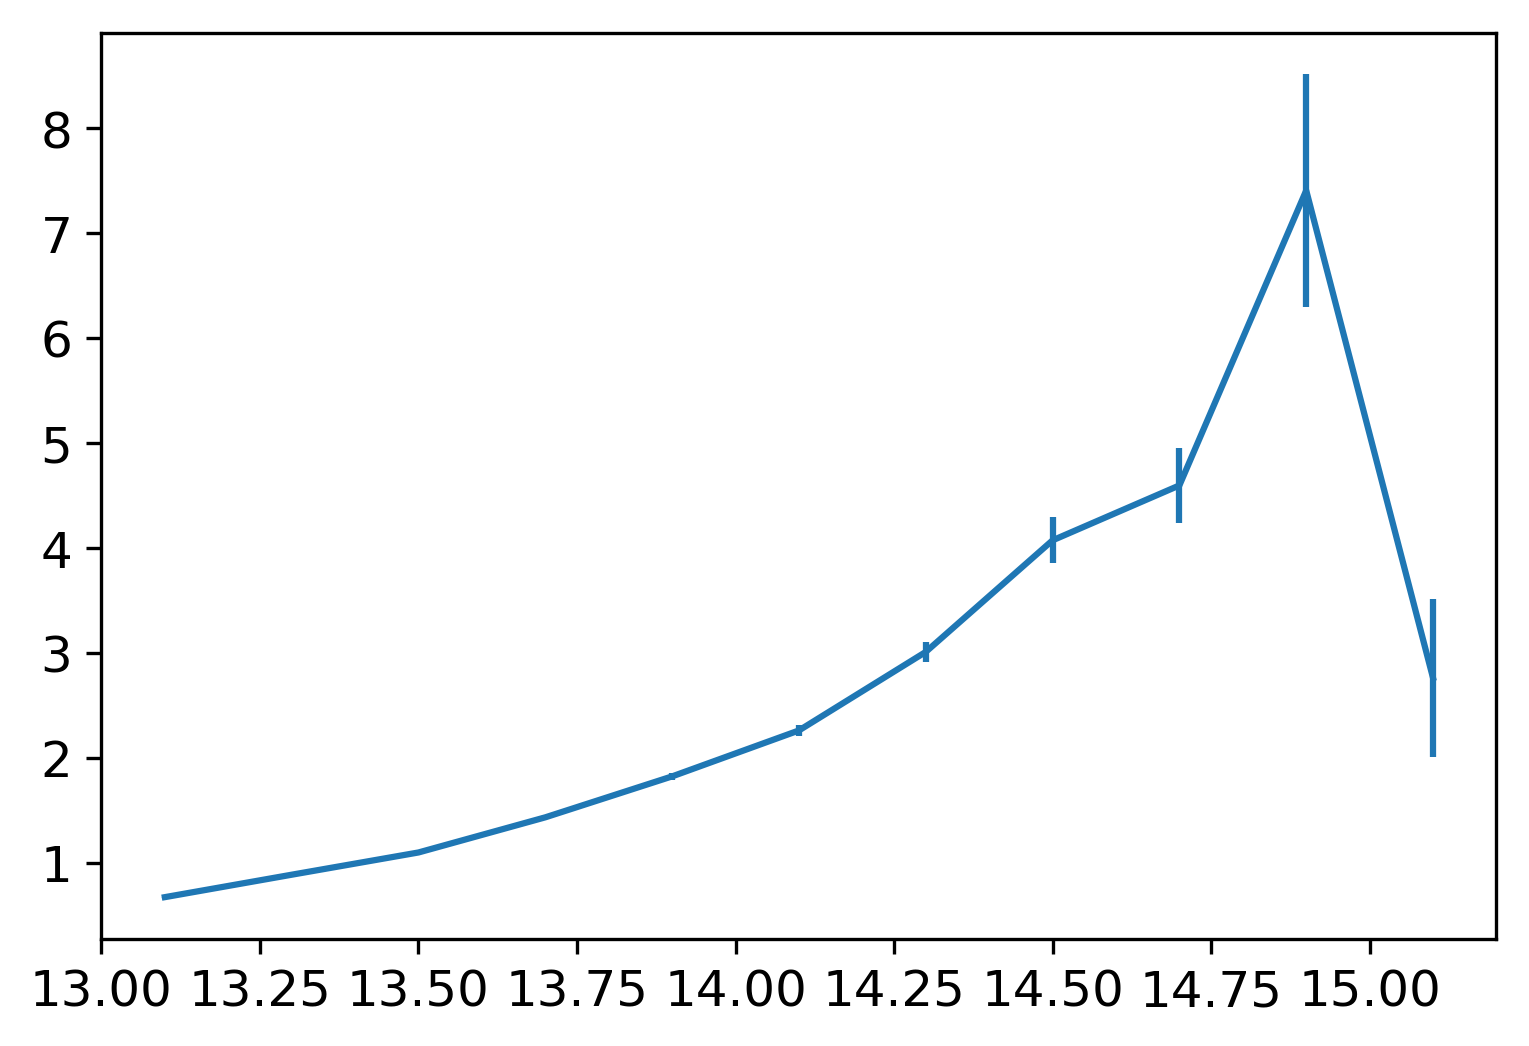

In [34]:
p.scatter.in_richness_at_fixed_hm(data_halo_cut)

### Old color plots

Out of 36491 clusters, 22803 have a richness > 0


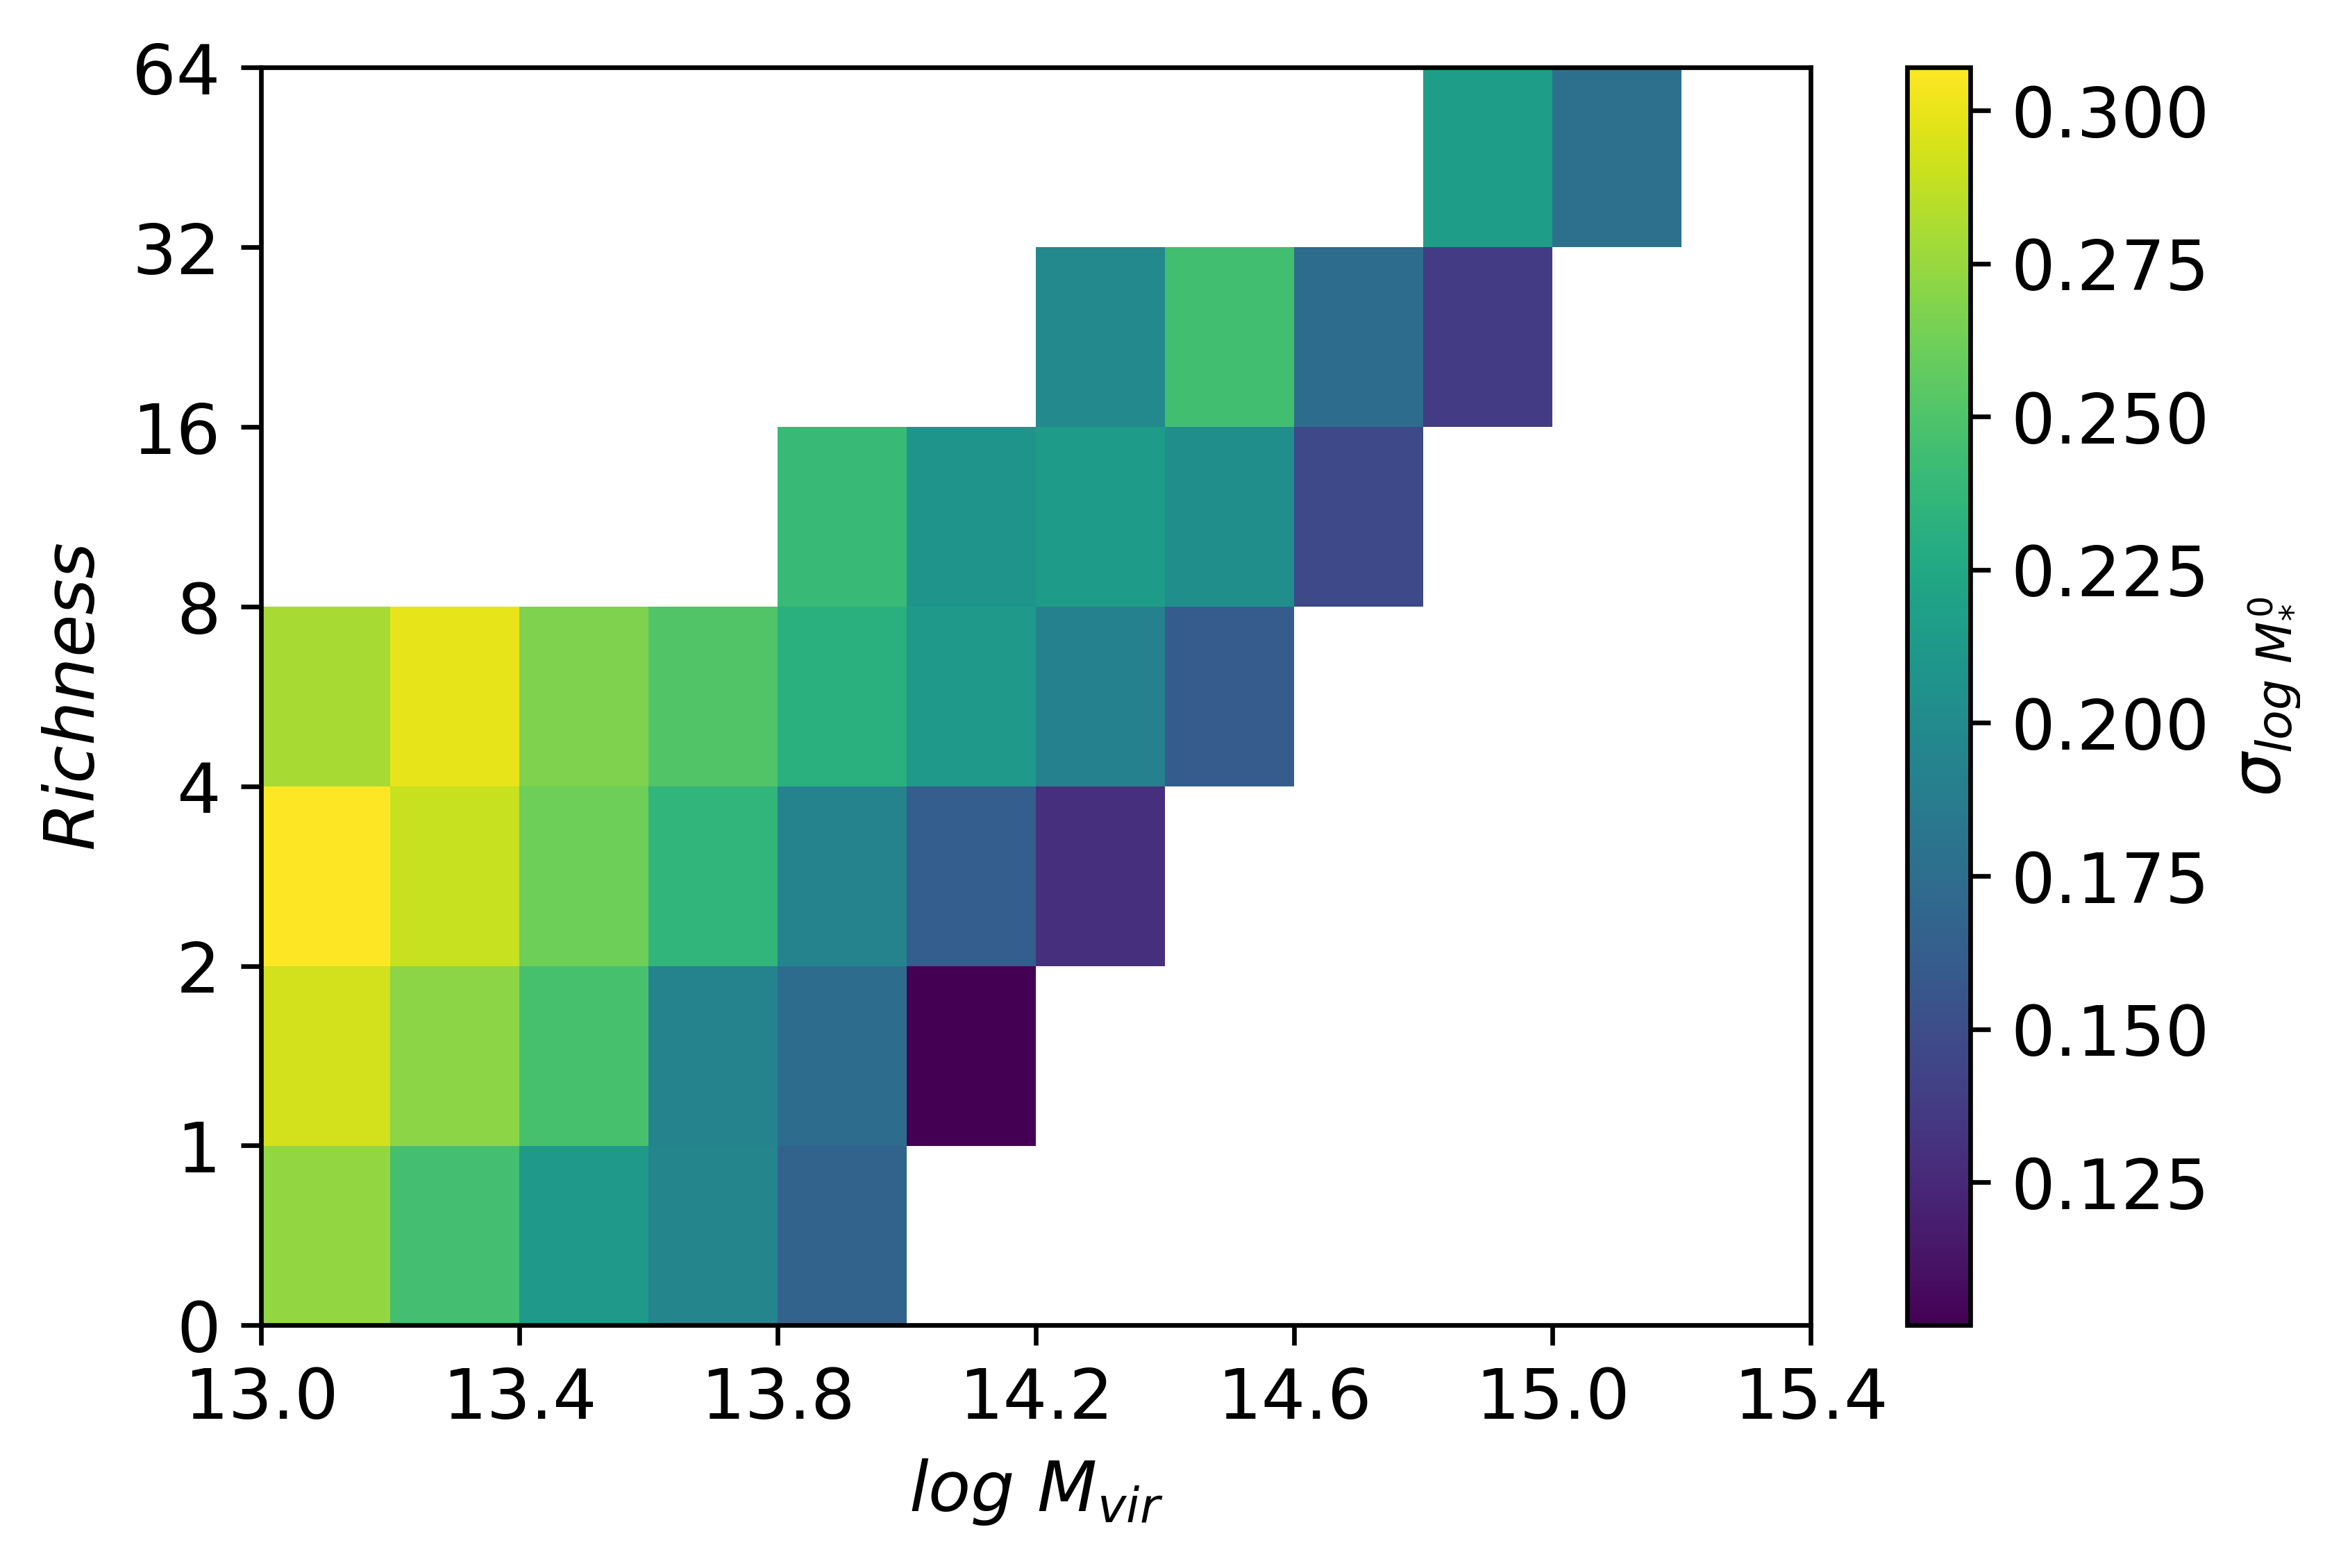

In [108]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

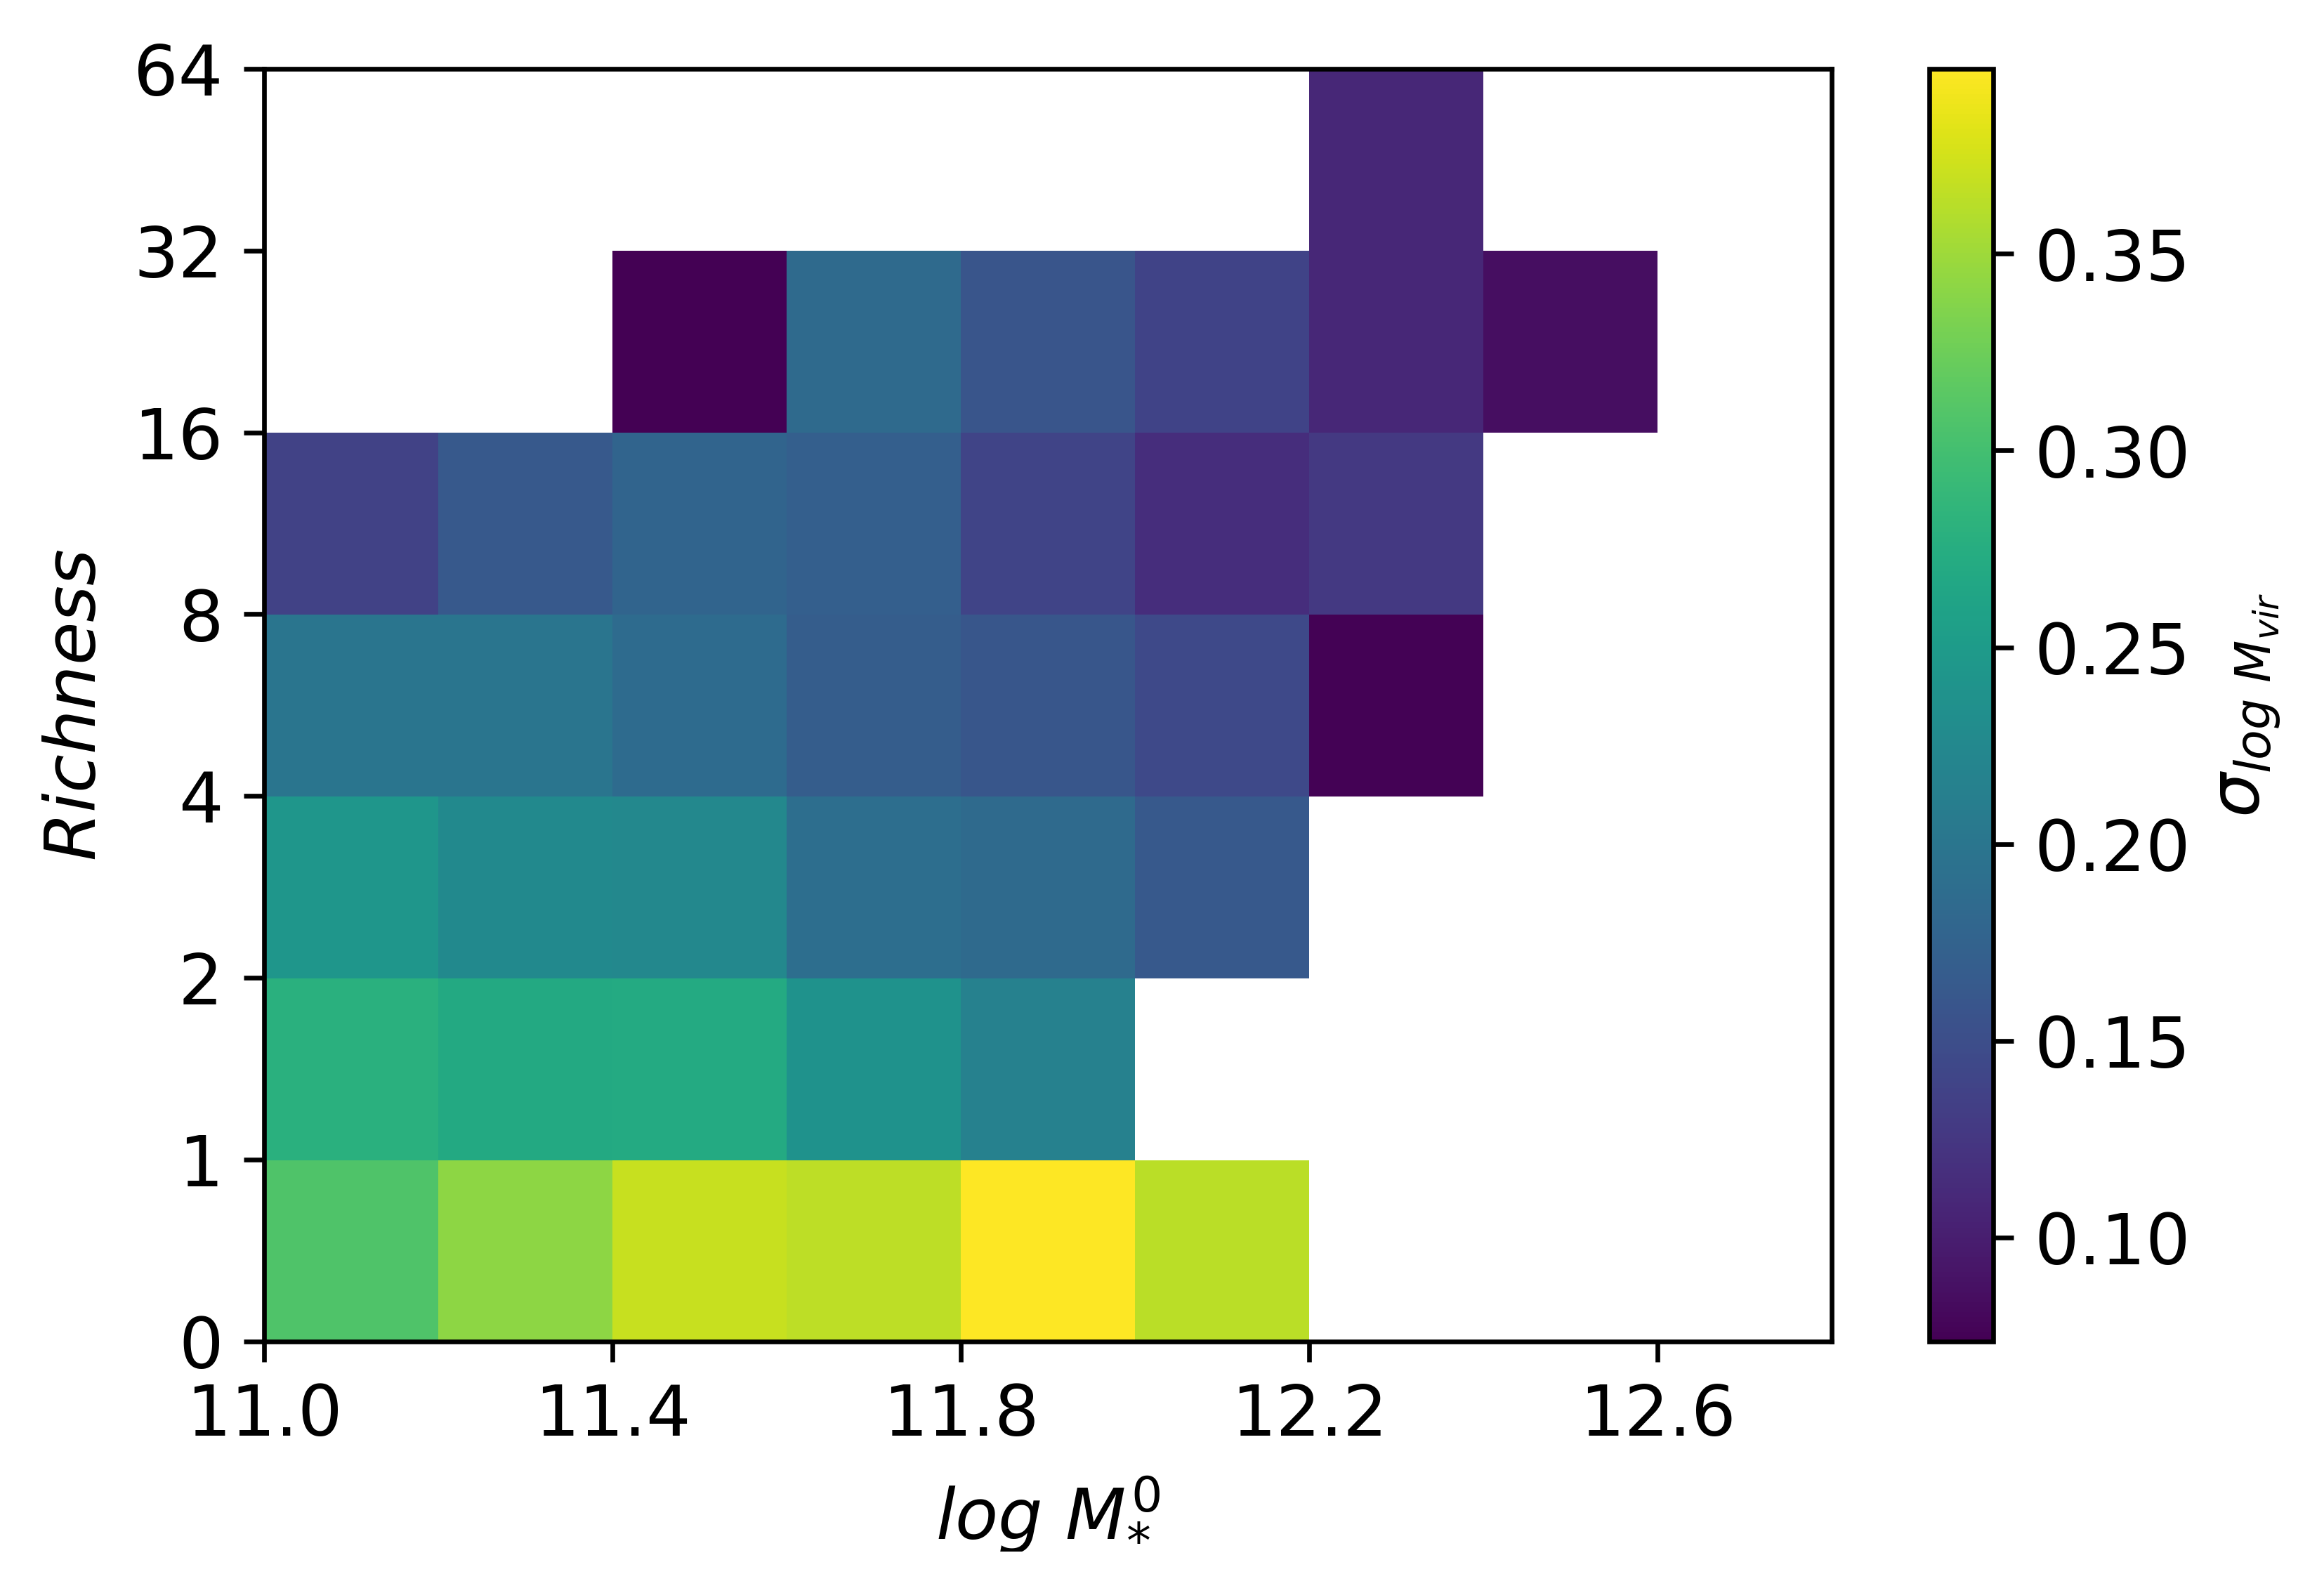

In [109]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Concentration

Same as richness but for concentration

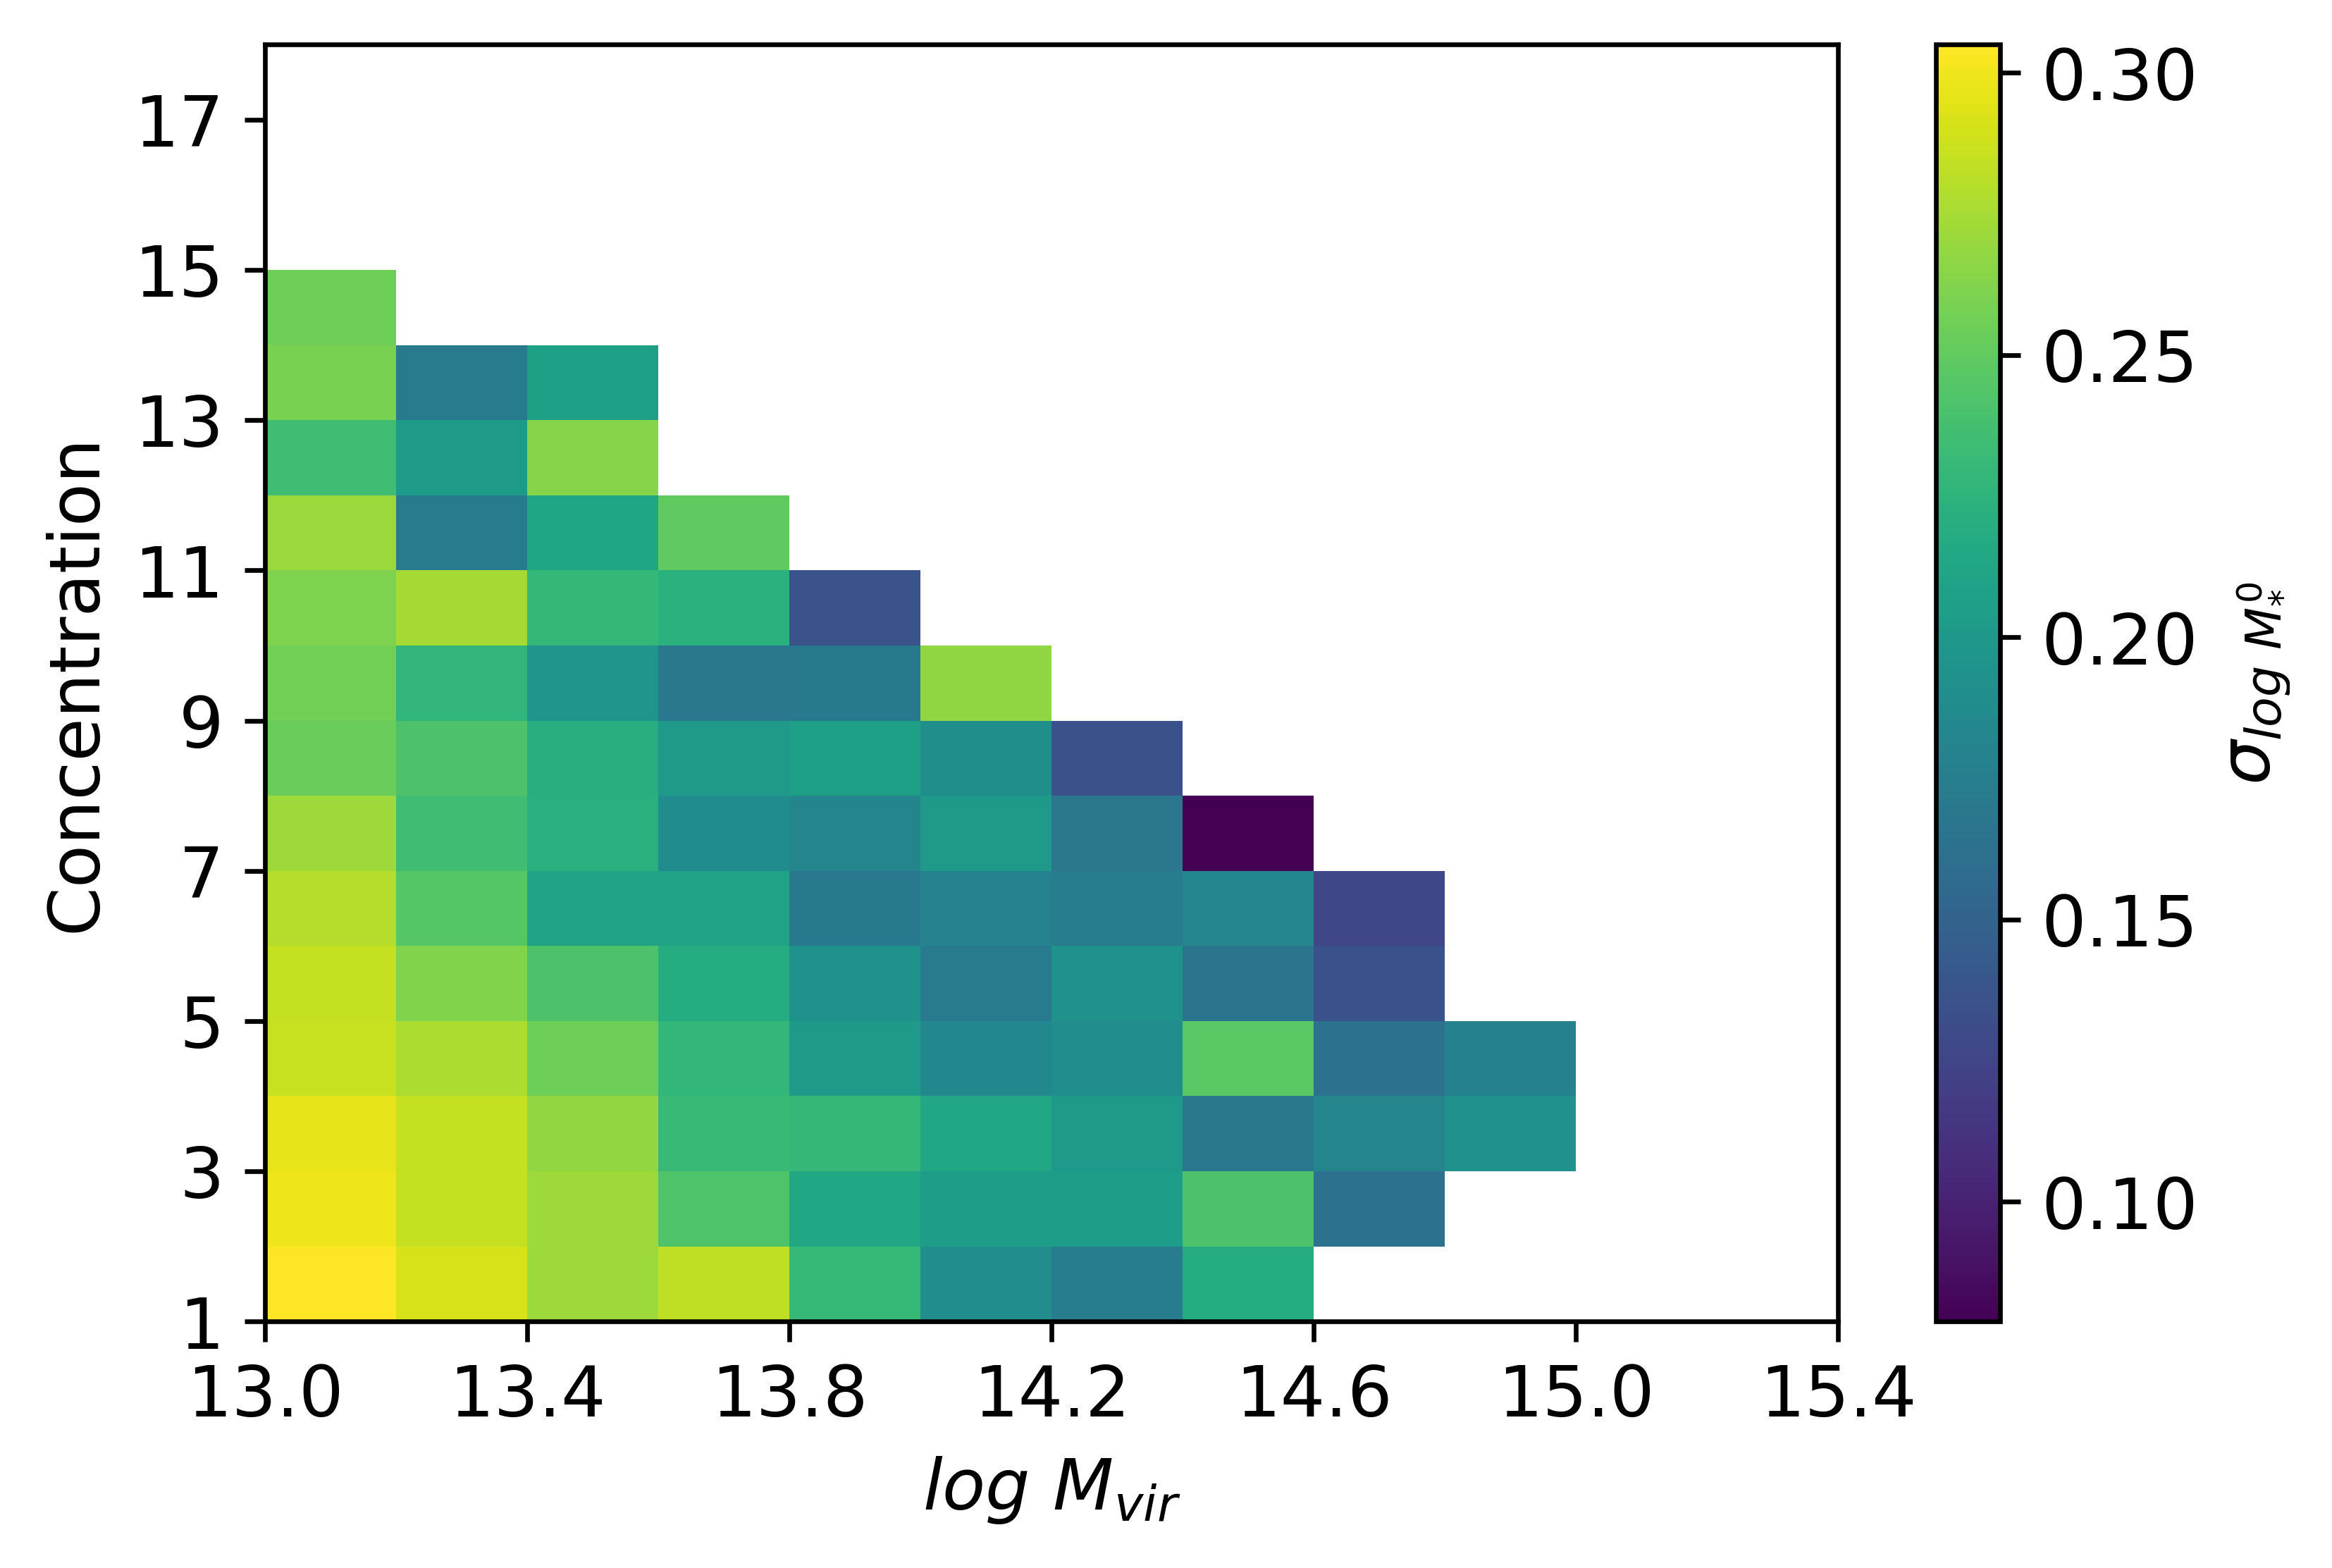

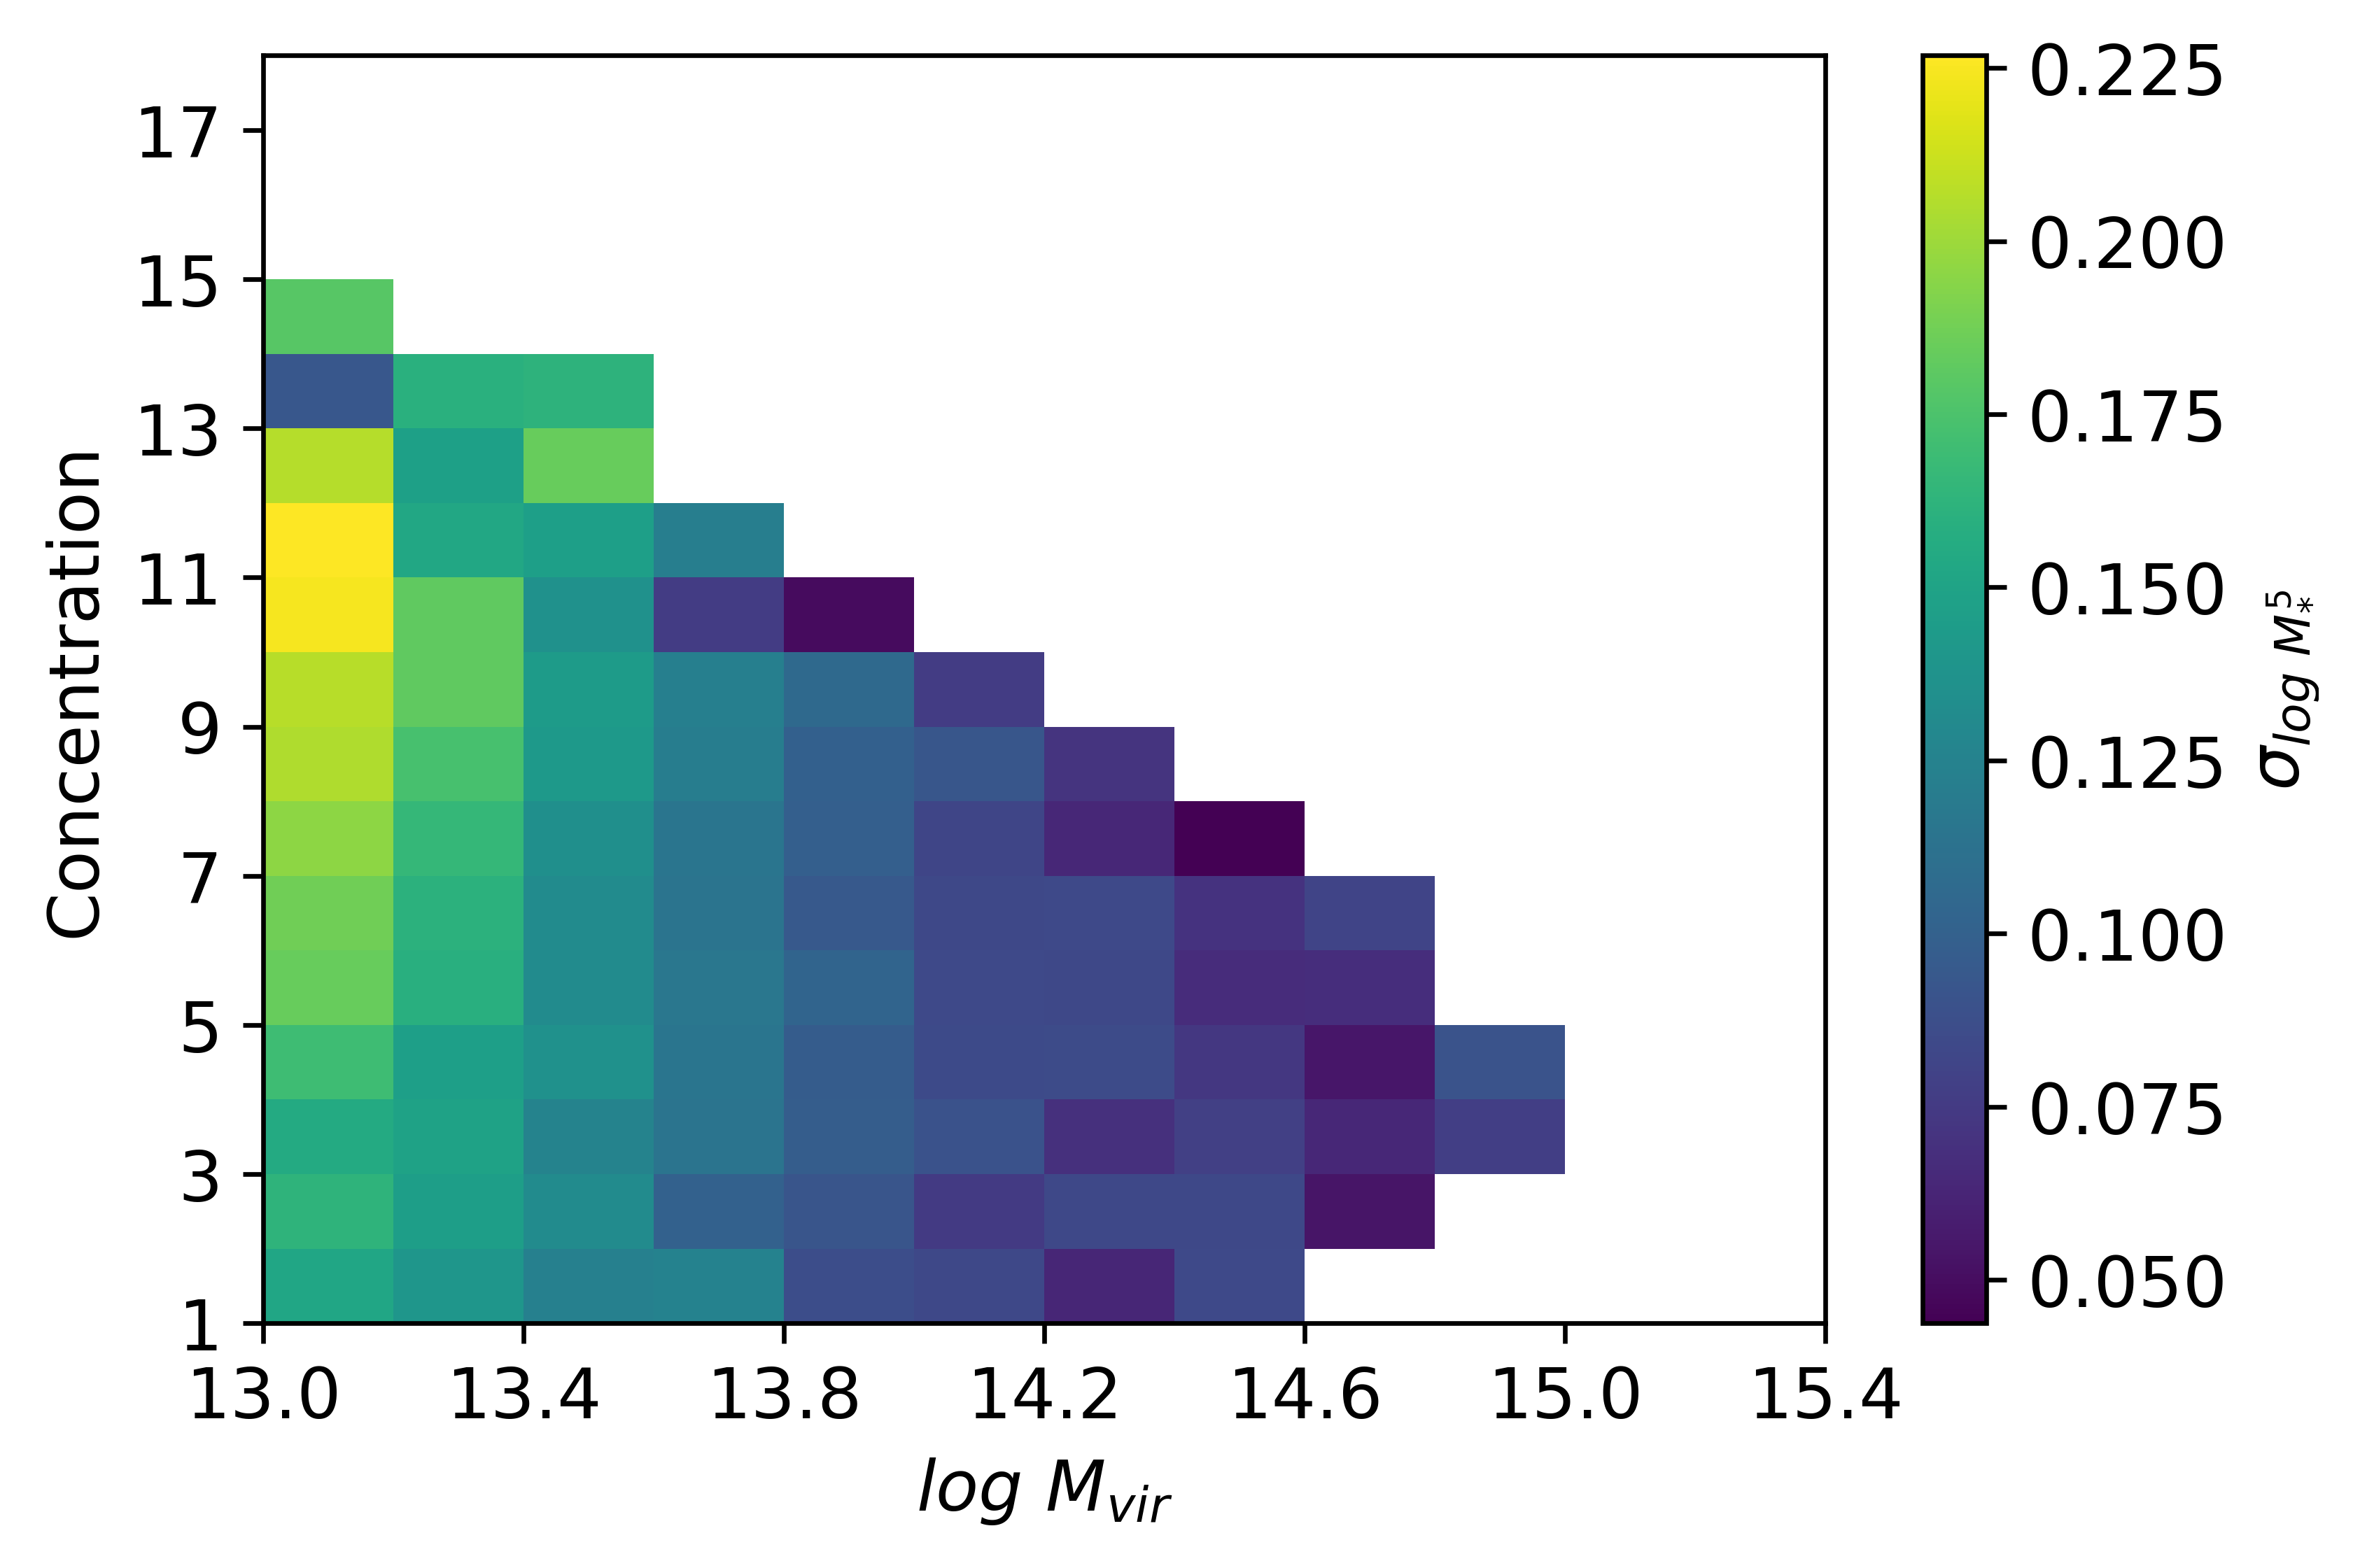

In [106]:
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

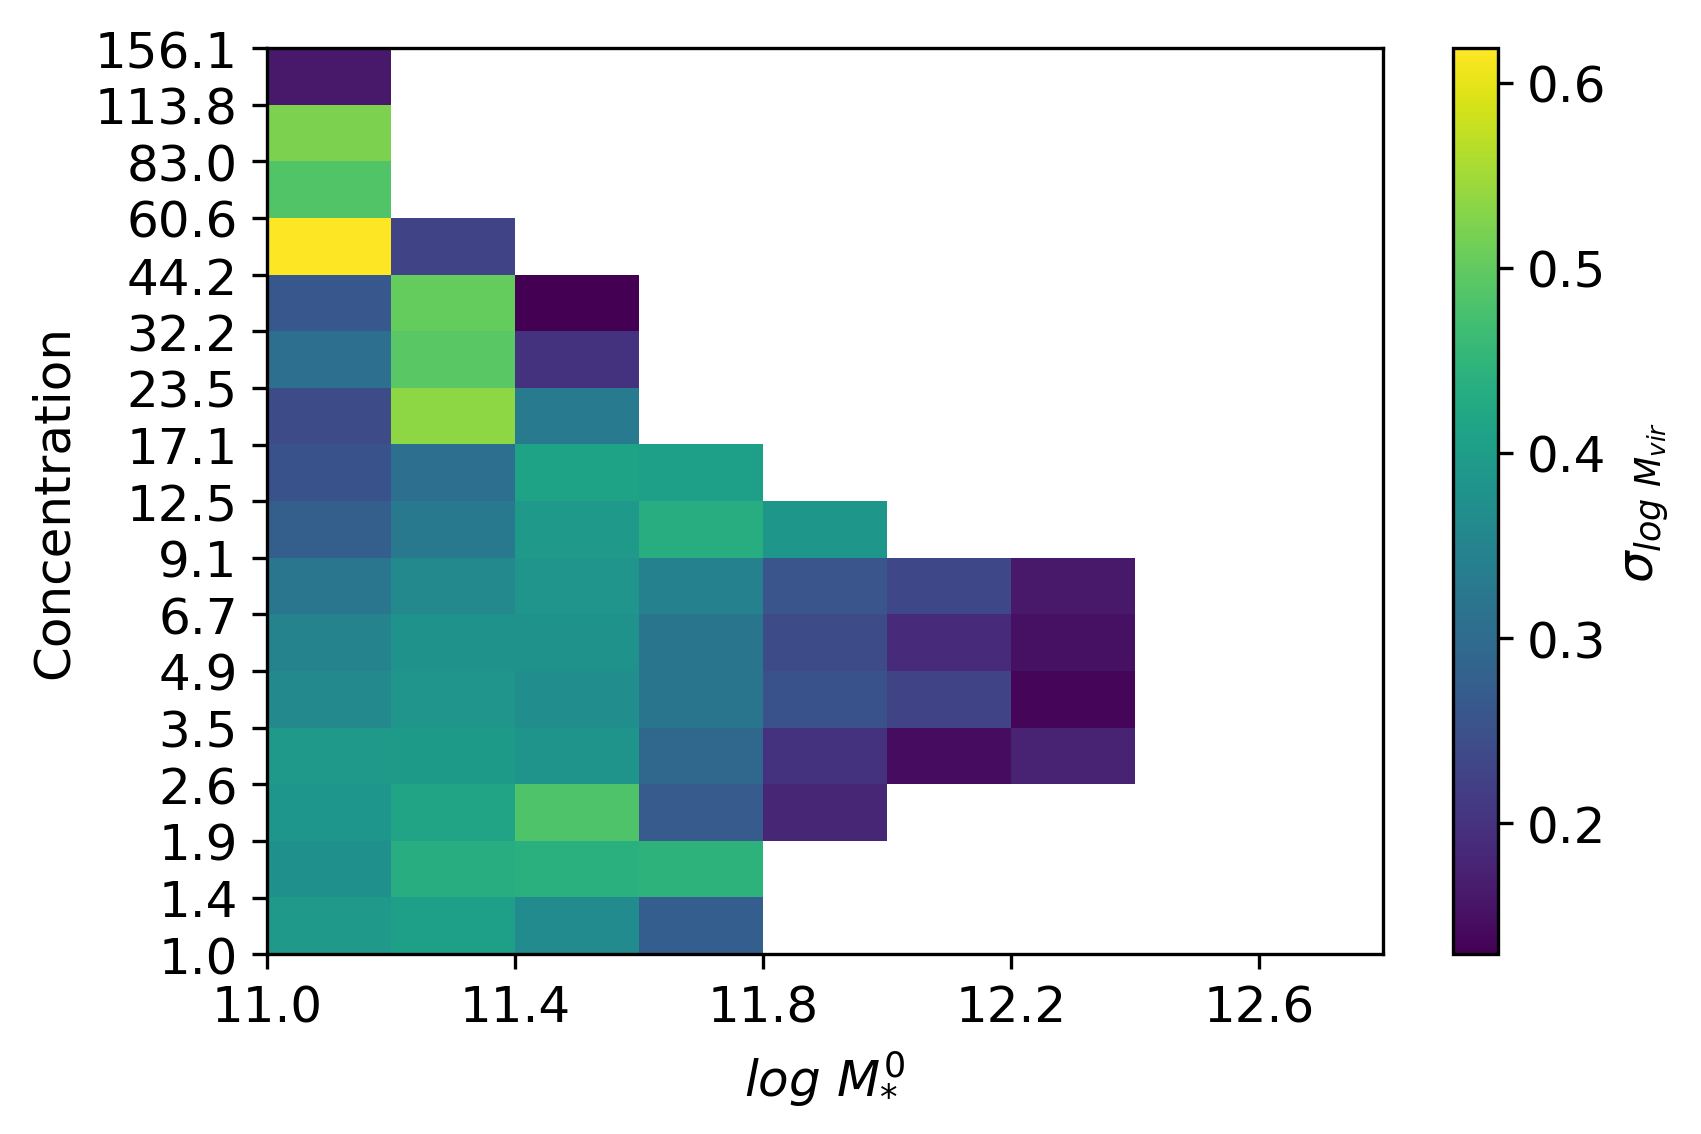

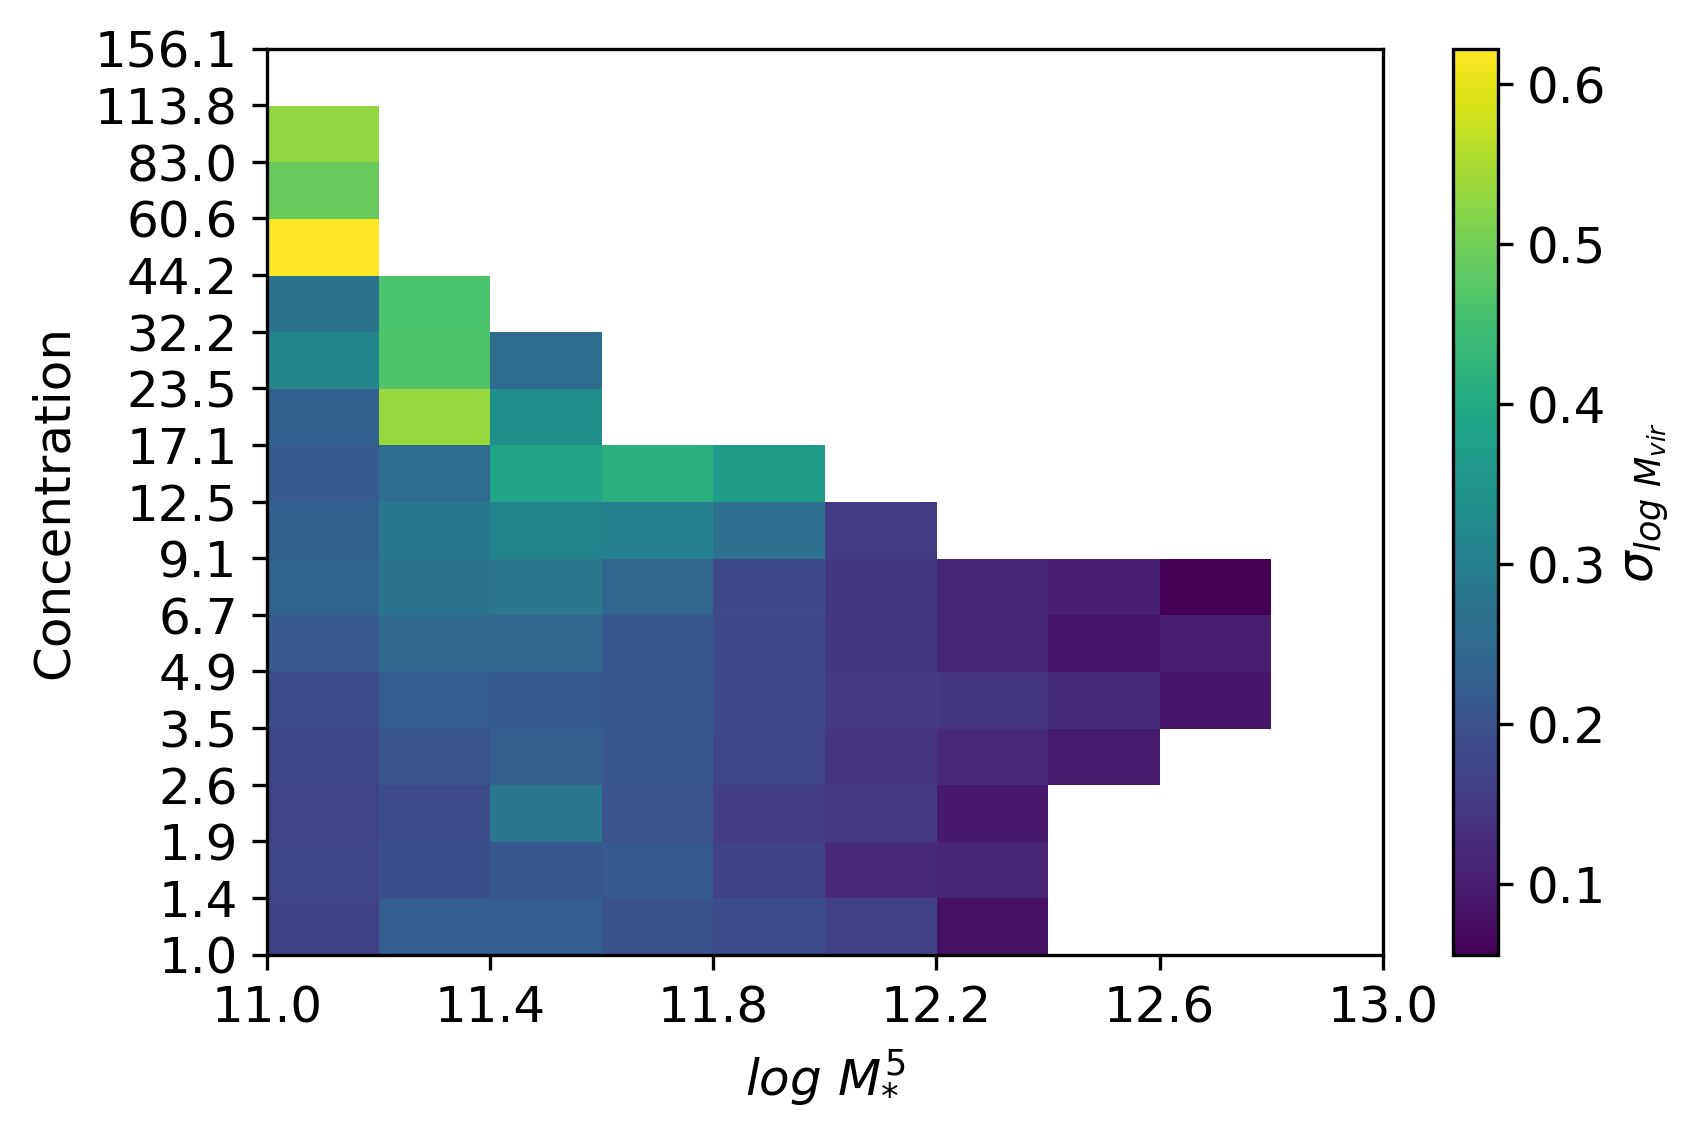

In [103]:
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"], 0)
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"], 5)

### Old

Just centrals
Total SM (including all sats)


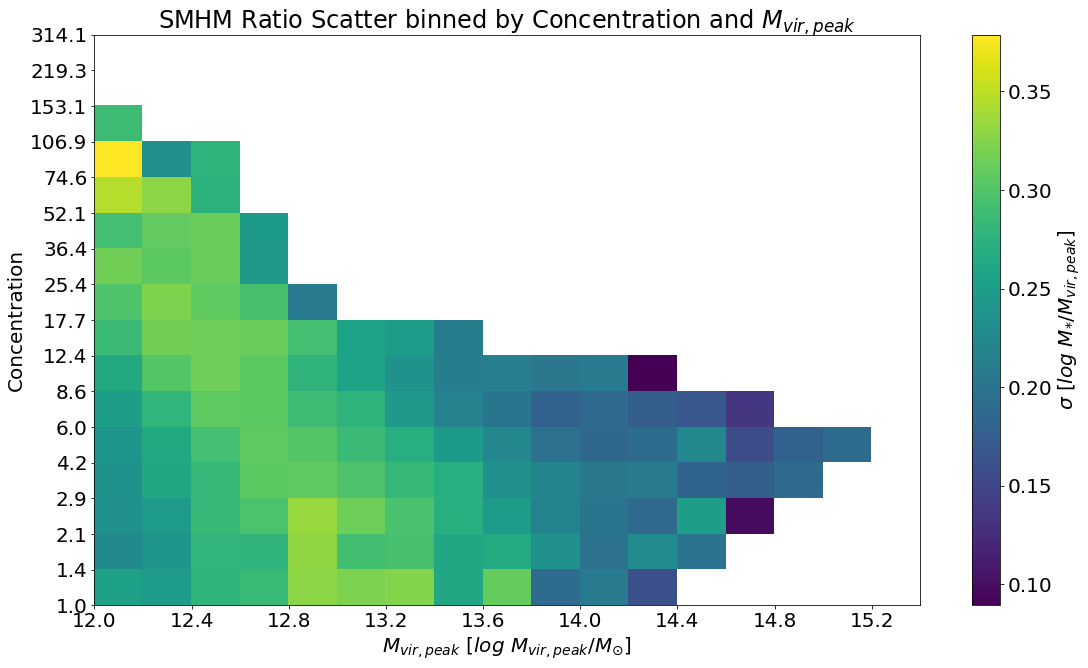

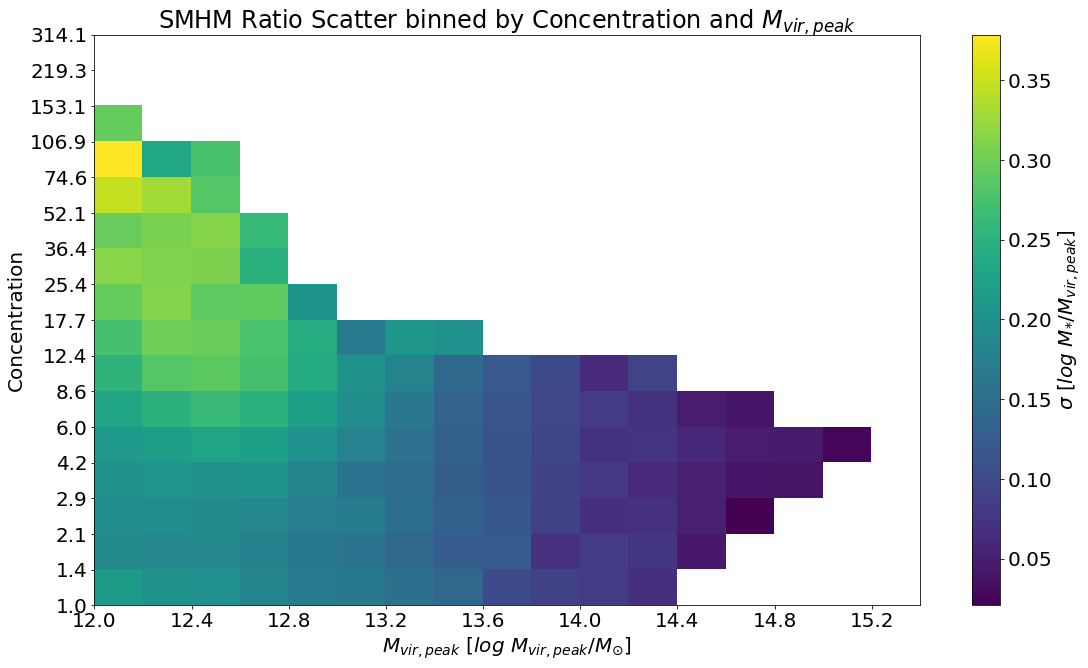

In [283]:
reload(plots)
# should probably have the centrals vs all in the title not just printed...
print("Just centrals")
plots.concentration_vs_scatter(centrals)
print("Total SM (including all sats)")
plots.concentration_vs_scatter(data["all"])

# Age

What about age?

In [548]:
print(data_halo_cut[0].dtype) # no obvious halfmass stellar scale

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]


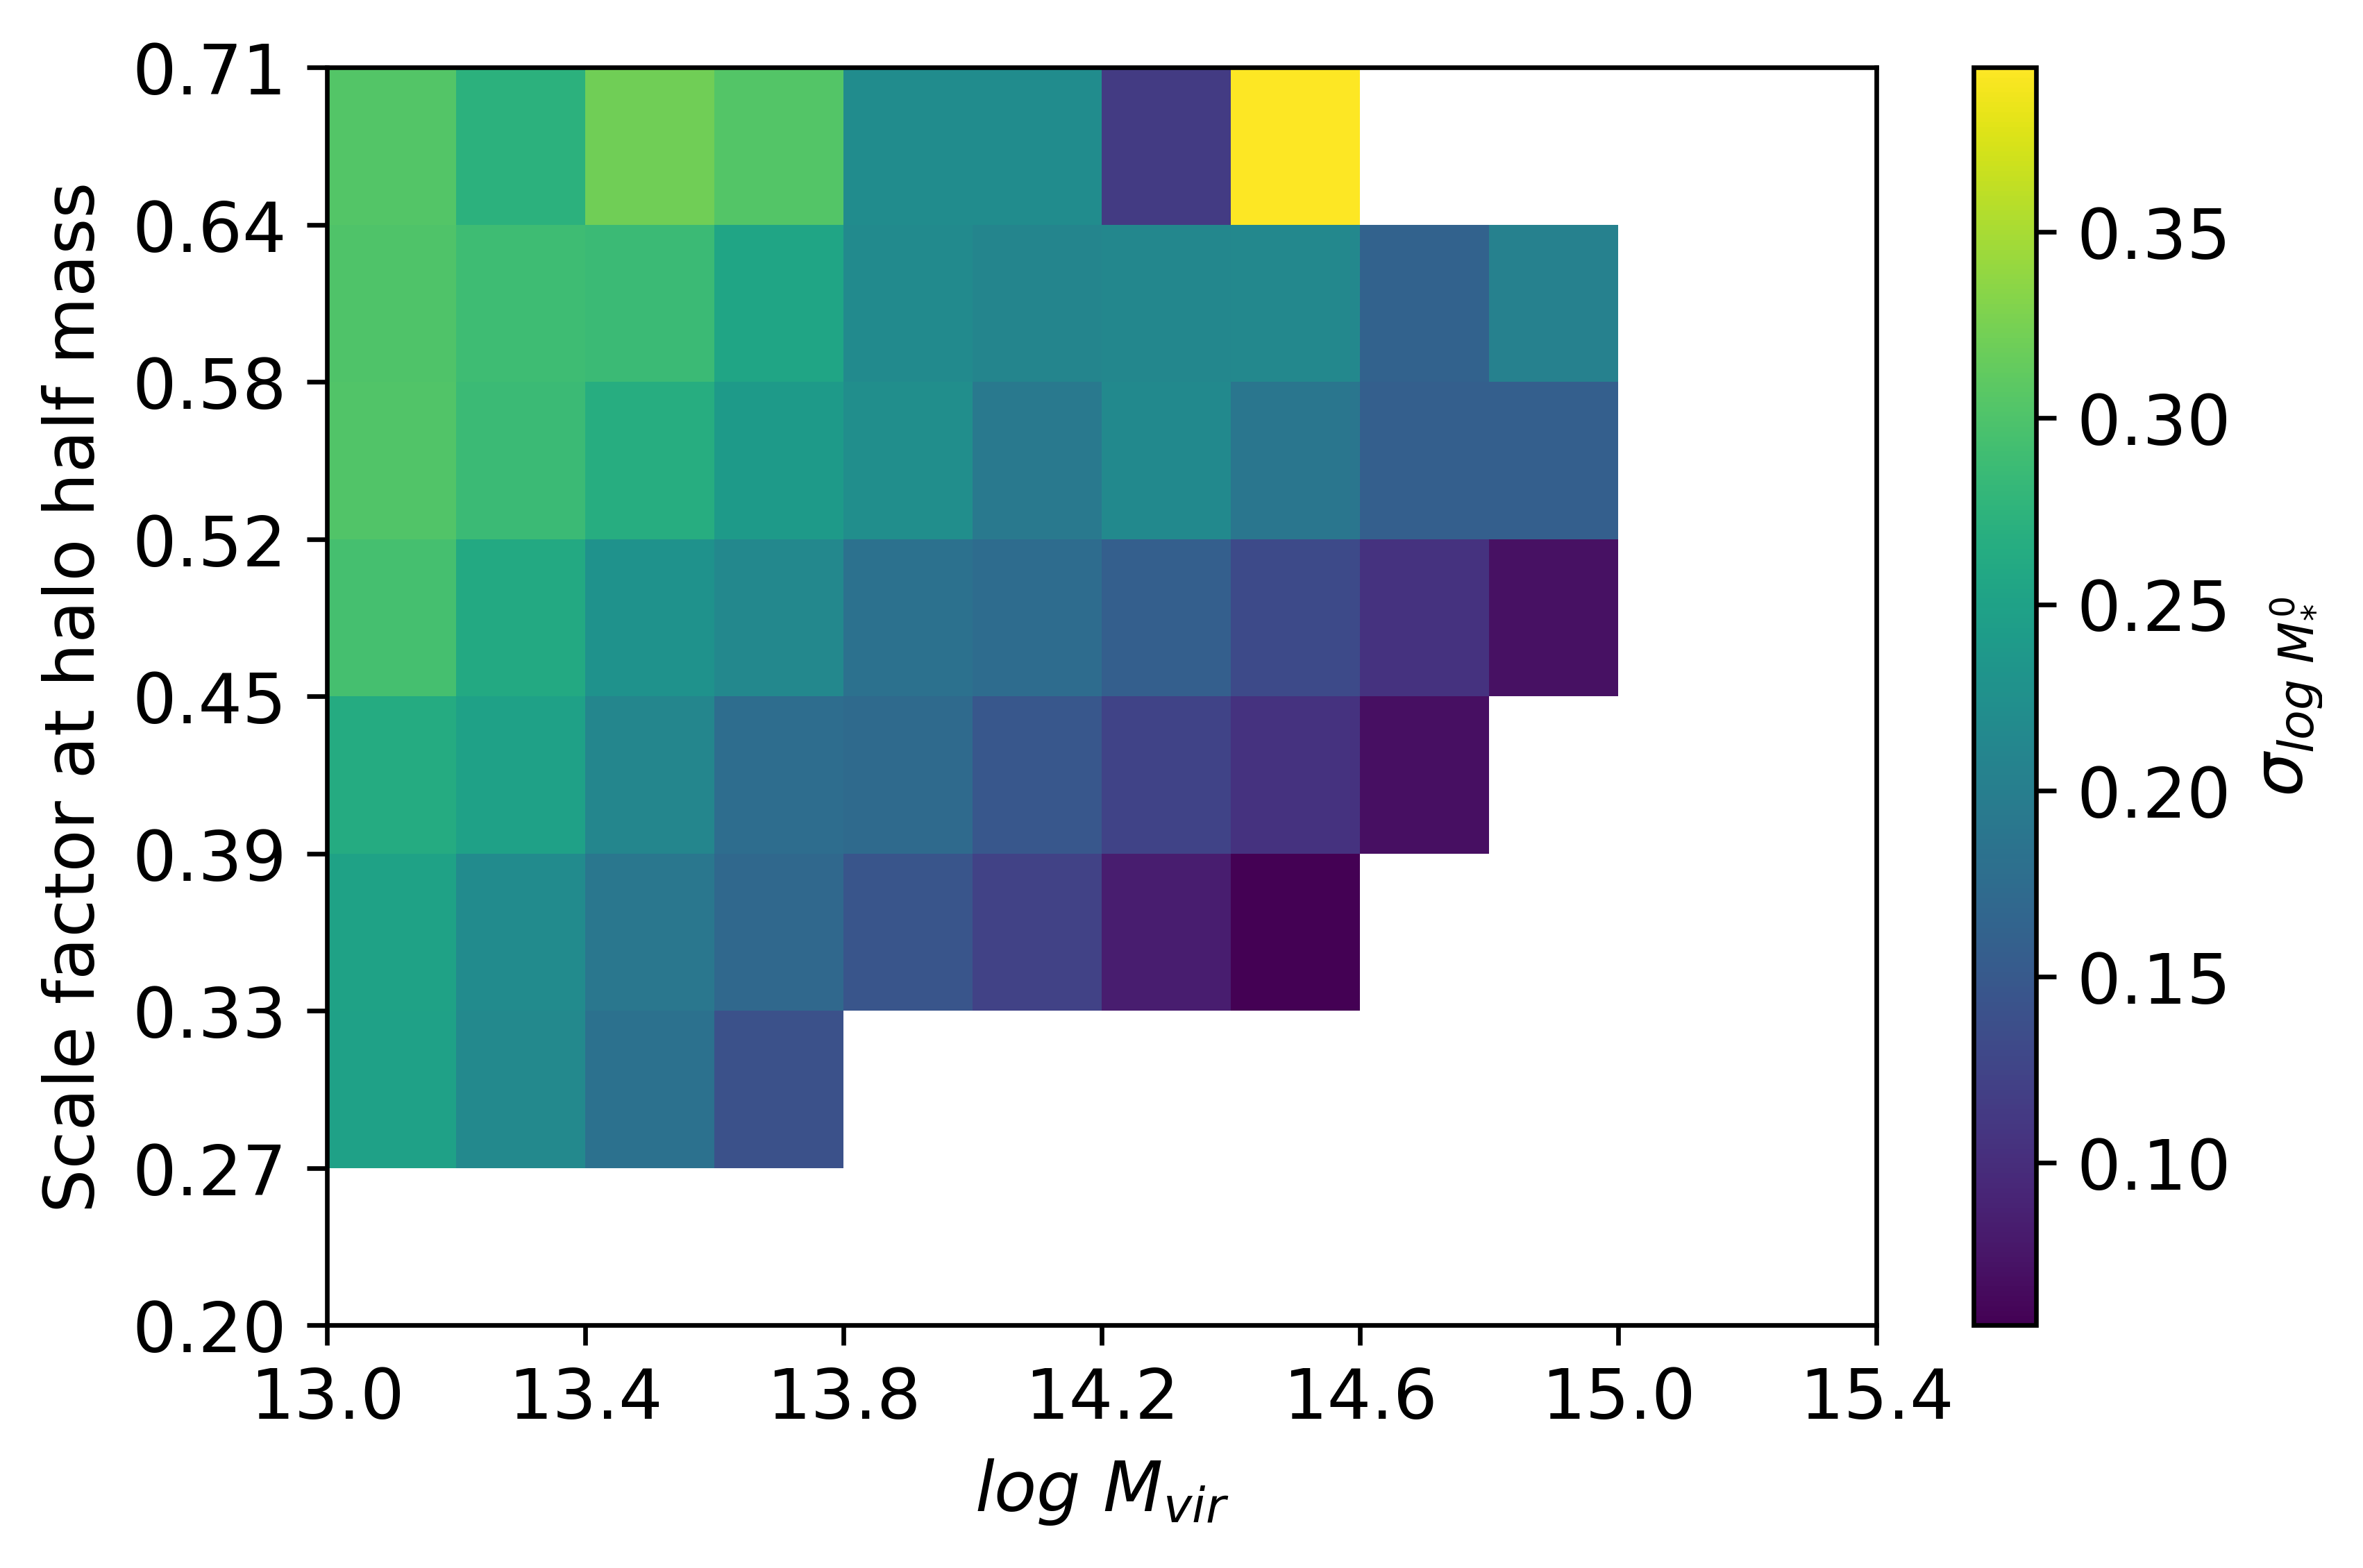

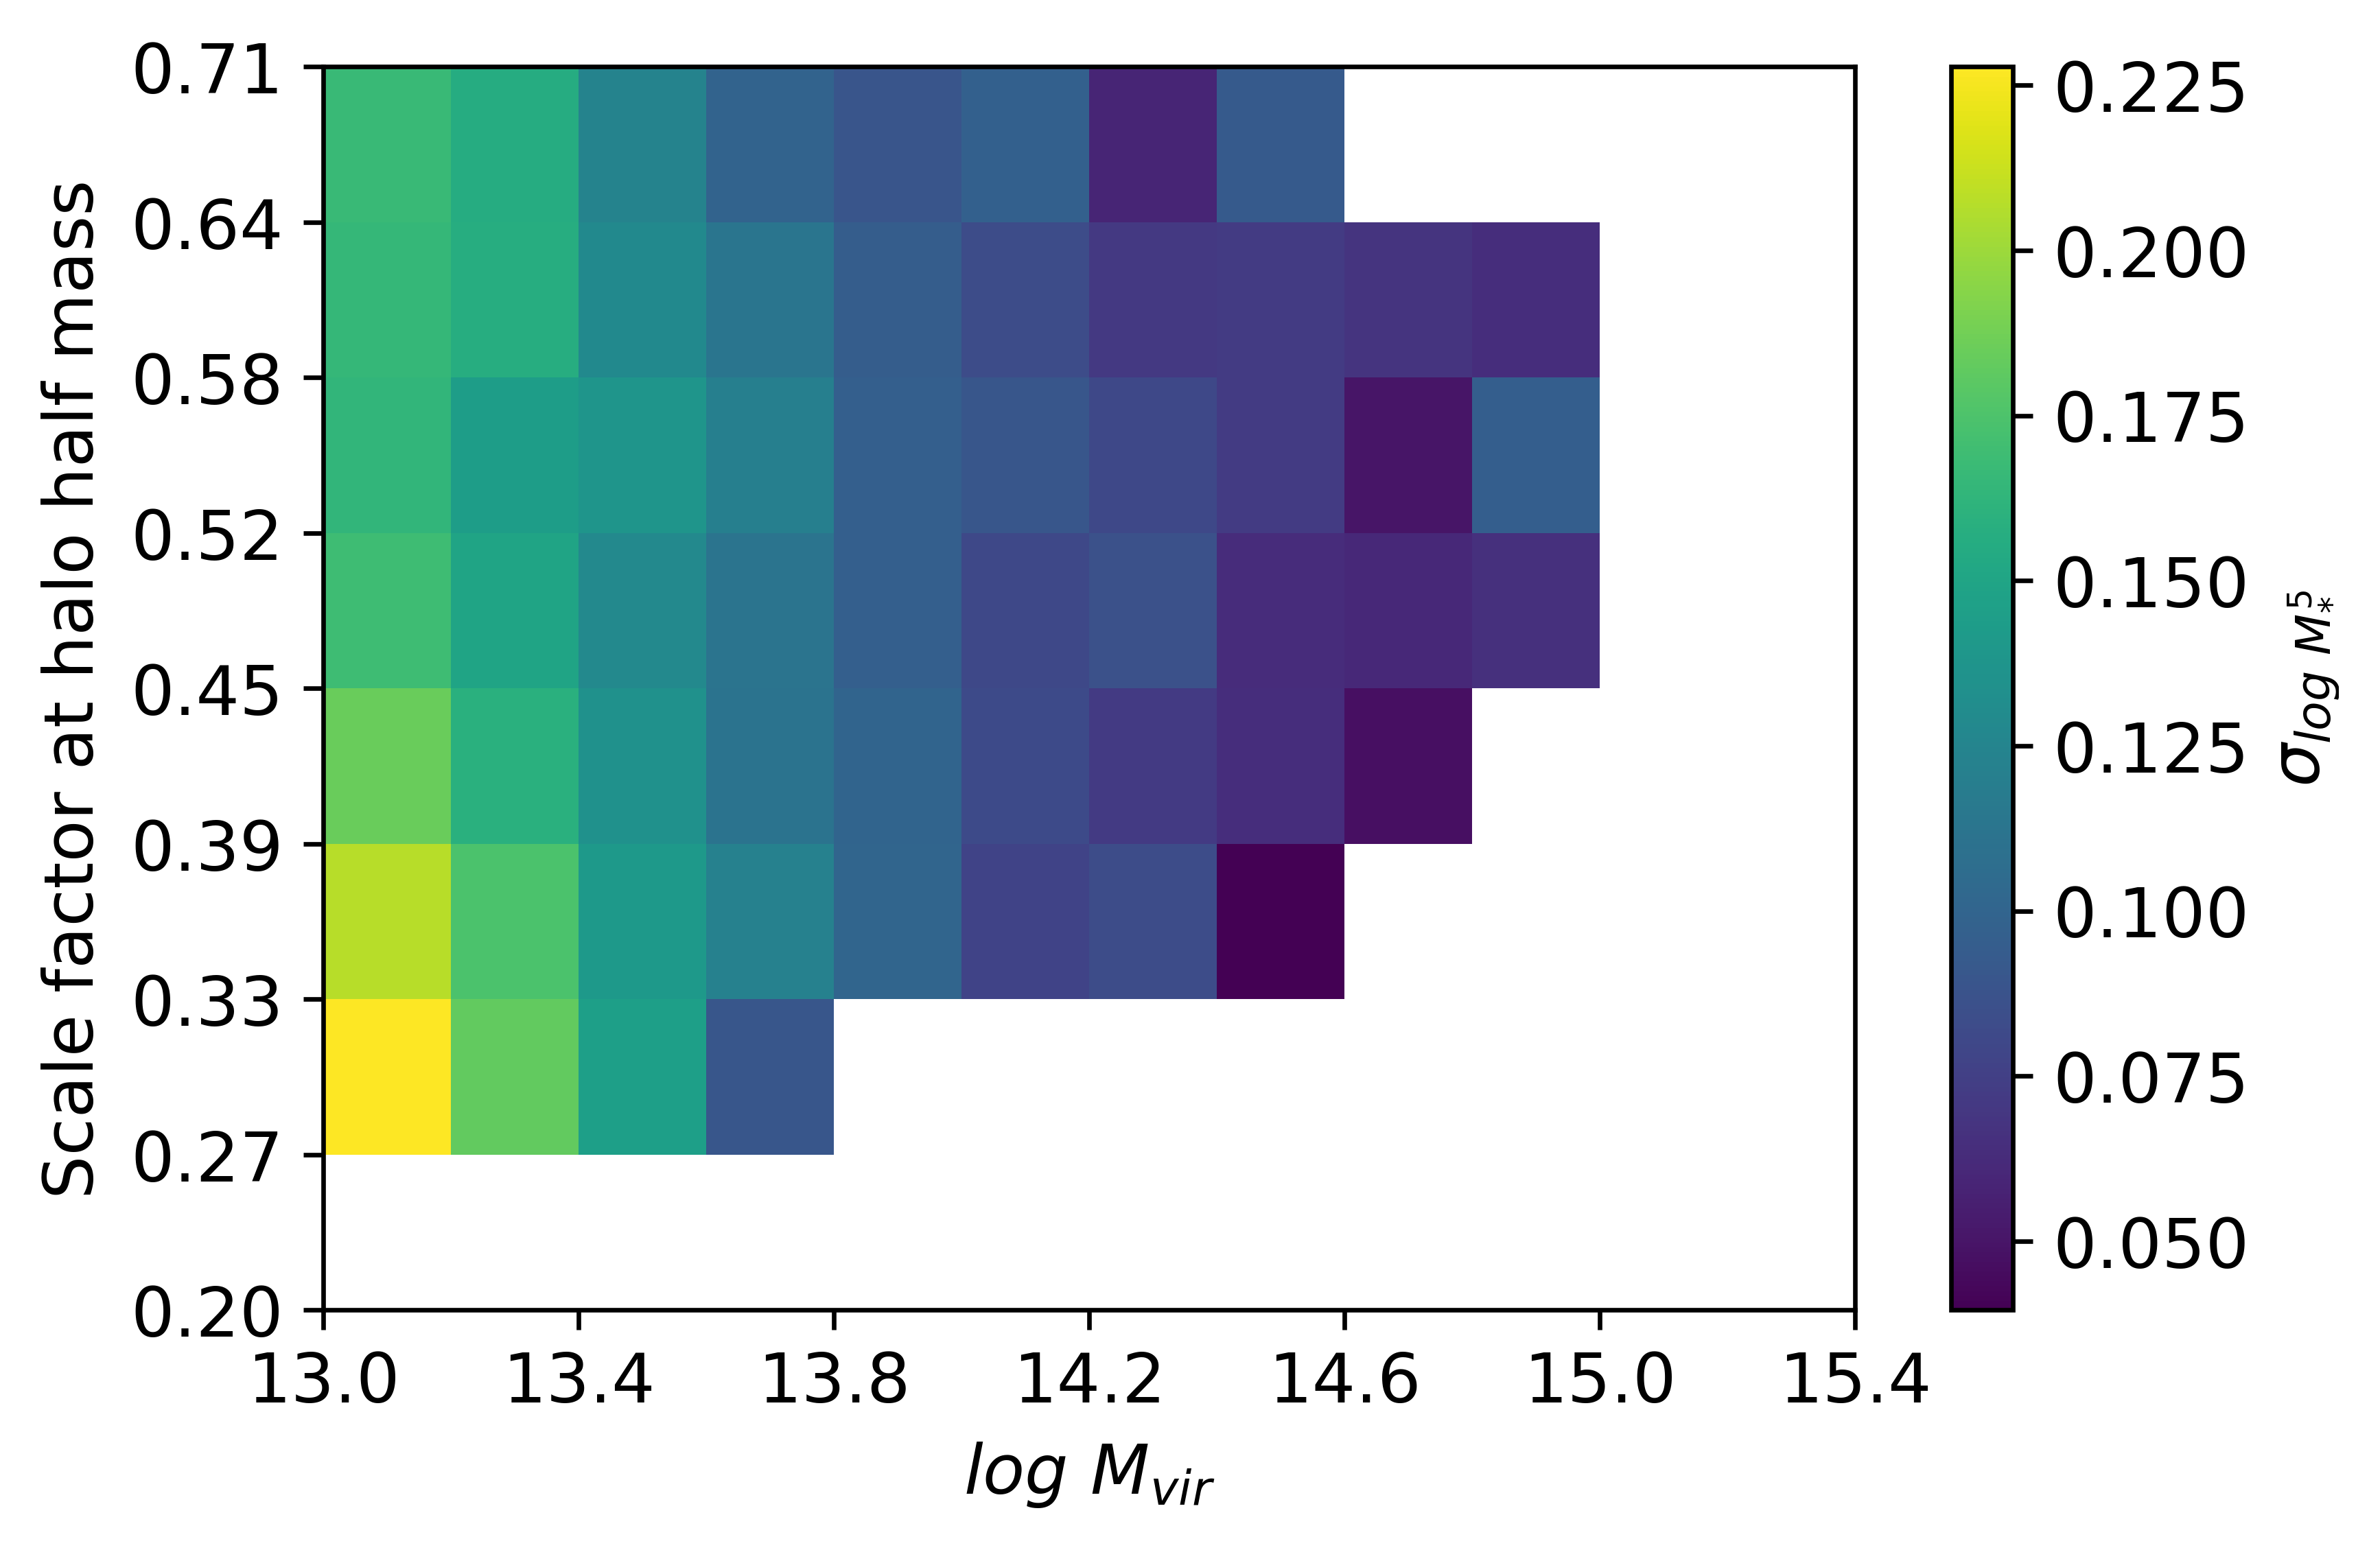

In [111]:
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

In [112]:
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])

TypeError: age_and_sm_vs_hm_scatter() missing 1 required positional argument: 'n_sats'

# Major Mergers

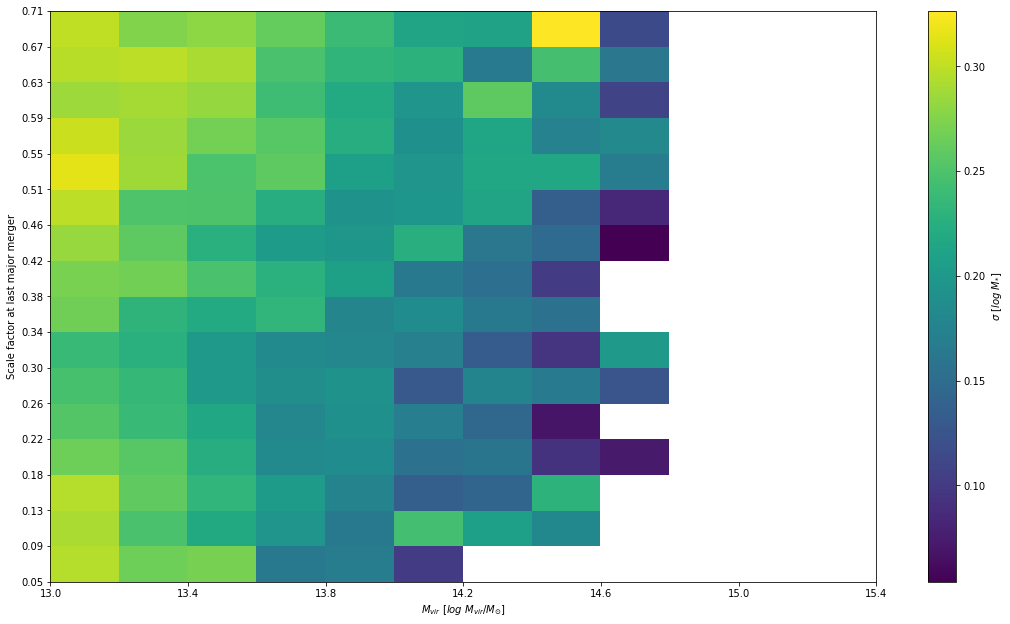

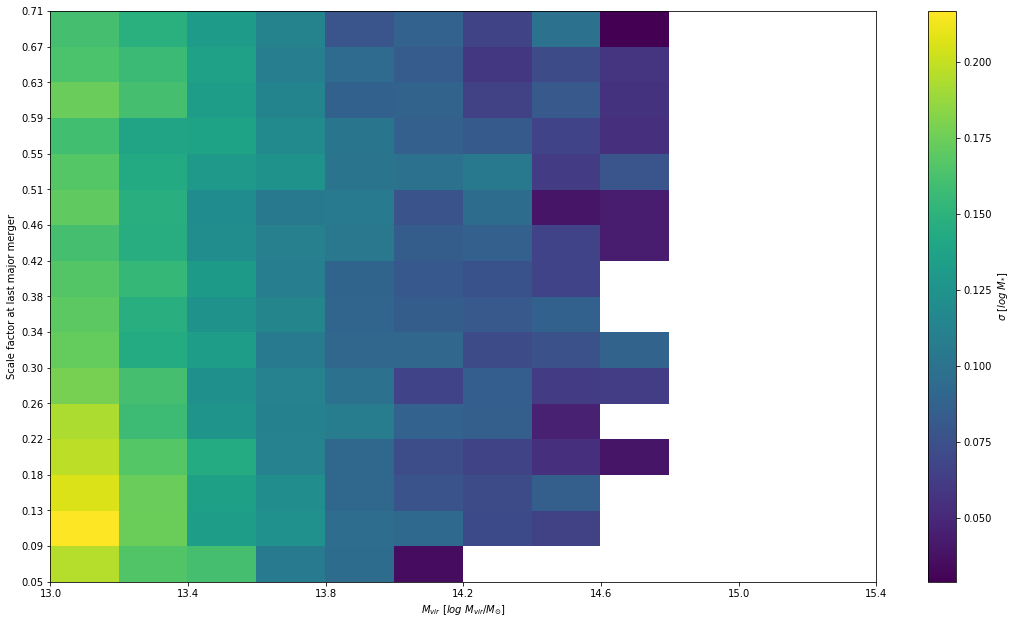

In [184]:
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"])
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"])

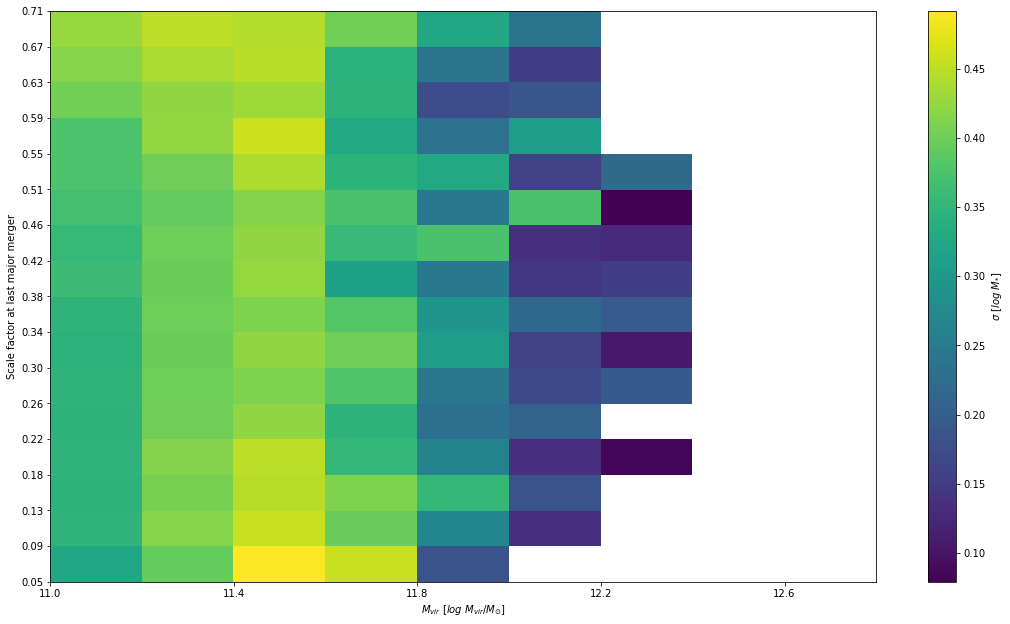

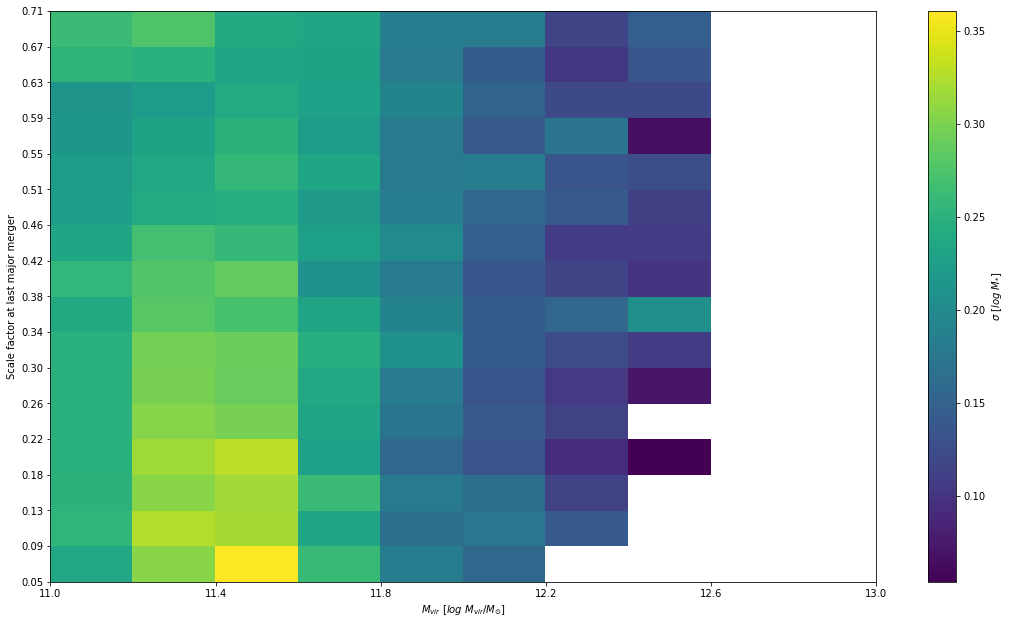

In [183]:
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])

# Comparison of secondary feature distribution

Let's look at how a selection on stellar mass could bias the secondary features.
1. Select a sample by cutting on some variant of SM
2. Select a sample by matching the halo mass distribution of 1
3. Compare features of 1 and 2

central cuts of (11.8, 12), halo cuts of [12.37672454 12.62522894]
872
Bin width is 0.039629056716972144
503
Bin width is 0.012171585690712305
872
Bin width is 0.039629056716972144
503
Bin width is 0.012171585690712305


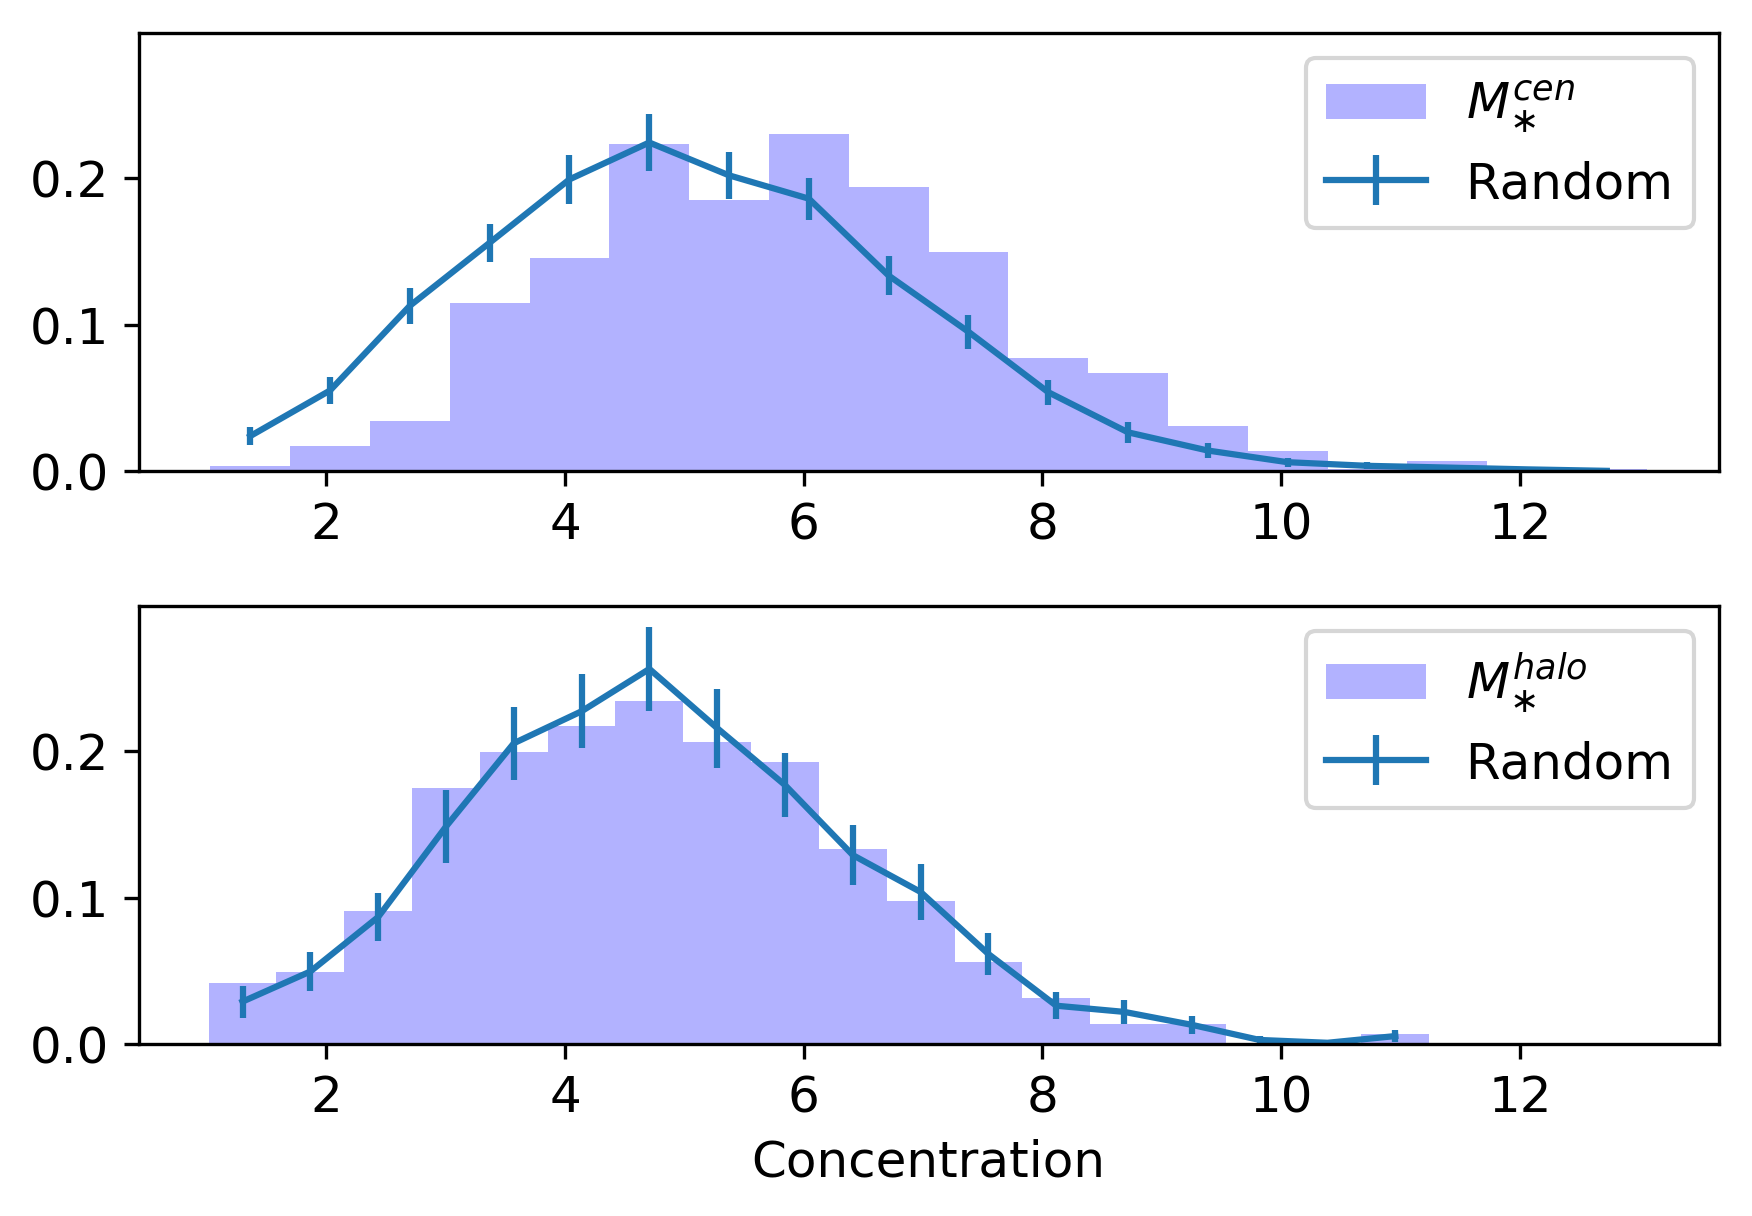

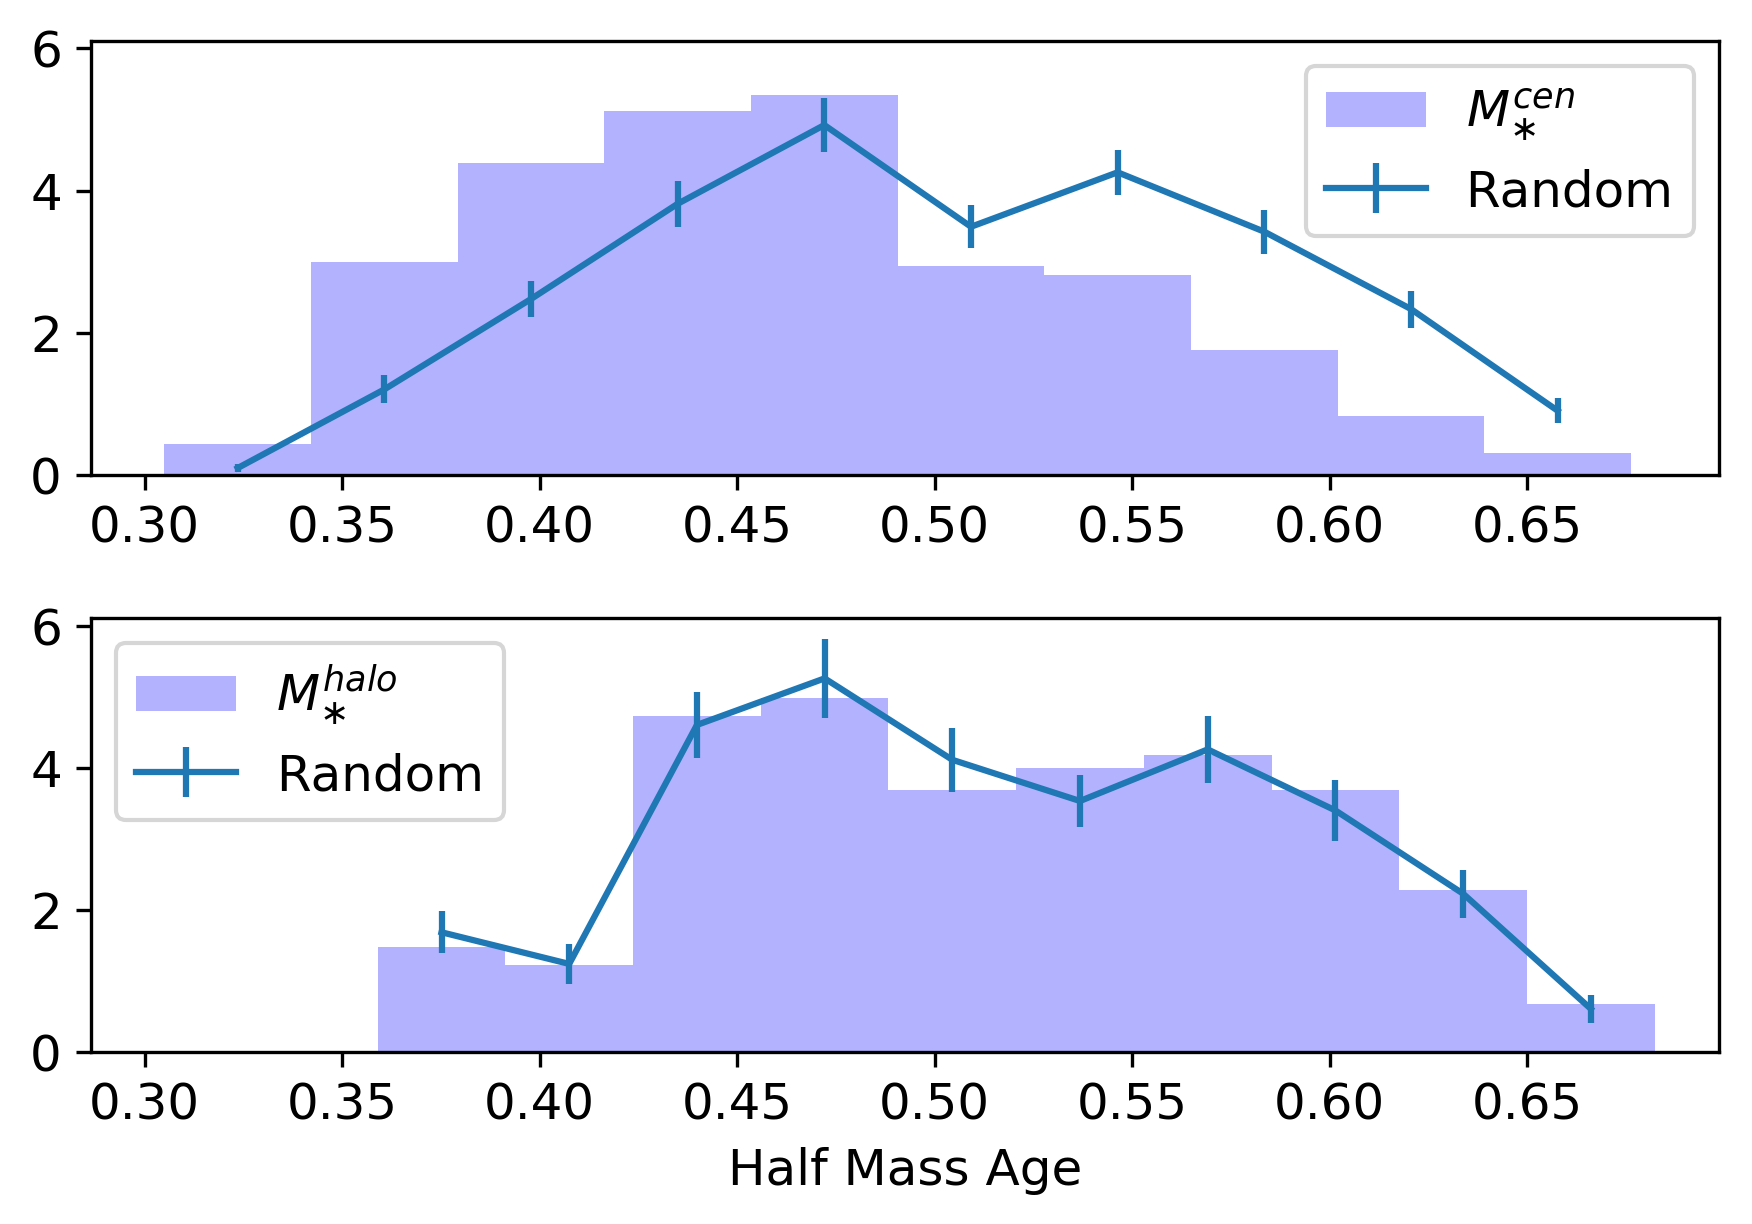

In [39]:
cen_cuts = (11.8, 12)
halo_cuts = smhm_fit.f_shmr(
    smhm_fit.f_shmr_inverse(cen_cuts, *data_halo_cut["cen"]["fit"]), 
    *data_halo_cut["halo"]["fit"])
print("central cuts of {}, halo cuts of {}".format(cen_cuts, halo_cuts))

_, axes = plt.subplots(2, 1)
same_hm_dist_plots.do_everything(data_halo_cut, "cen", same_hm_dist_plots.f_concentration, cuts=cen_cuts, ax=axes[0])
same_hm_dist_plots.do_everything(data_halo_cut, "halo", same_hm_dist_plots.f_concentration, cuts=halo_cuts, ax=axes[1])
plt.tight_layout()
axes[1].set(**{"xlabel": "Concentration"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})


# You need to think about how you are binning this.
_, axes = plt.subplots(2, 1)
ax = same_hm_dist_plots.do_everything(data_halo_cut, "cen", same_hm_dist_plots.f_age, cuts=cen_cuts, ax=axes[0], bins=10)
ax = same_hm_dist_plots.do_everything(data_halo_cut, "halo", same_hm_dist_plots.f_age, cuts=halo_cuts, ax=axes[1], bins=10)
plt.tight_layout()
axes[1].set(**{"xlabel": "Half Mass Age"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})
"""
_, axes = plt.subplots(1, 2)
ax = same_hm_dist_plots.do_everything(data_halo_cut, "cen", same_hm_dist_plots.f_mm, cuts=(11.8, 12), bulk_set={"xlabel": "Scale at last MM"}, ax=axes[0])
ax = same_hm_dist_plots.do_everything(data_halo_cut, "halo", same_hm_dist_plots.f_mm, cuts=(11.8, 12), bulk_set={"xlabel": "Scale at last MM"}, ax=axes[1])
plt.tight_layout()
"""
None